In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import sklearn.preprocessing
import sklearn.model_selection

In [6]:
import uproot
uproot.default_library = "np"

In [7]:
import os.path

In [8]:
import logging
logging.basicConfig(level=logging.INFO)

In [9]:
np.set_printoptions(precision=4, suppress=True)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data

In [11]:
raw_names = [
    "RapidSim/B2Kee_tree.root:DecayTree;29",
    "RapidSim/B2KJpsi2ee_tree.root:DecayTree;36",
    "RapidSim/B2Kpsi2s2ee_tree.root:DecayTree;37",
    "RapidSim/D2phipi2ee_tree.root:DecayTree;31",
]

In [12]:
raw_files = [uproot.open(os.path.join(os.path.expanduser("~/2021/"), name)) for name in raw_names]

In [13]:
def true_features(f):
    return [name for name in f.keys() if "TRUE" in name]
def common_features(*fs):
    return sorted(set.intersection(*[set(true_features(f)) for f in fs]))
common_features(*raw_files)

['angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Truthing

In [14]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_TRUE > %g" % v1, "q2_TRUE < %g" % v2)

In [15]:
aliases = {
    #"BM":     "sqrt(B_plus_TRUEP_E**2-B_plus_TRUEPT**2-B_plus_TRUEP_Z**2)",
    "ll_E":   "e_plus_TRUEP_E + e_minus_TRUEP_E",
    "ll_X":   "e_plus_TRUEP_X + e_minus_TRUEP_X",
    "ll_Y":   "e_plus_TRUEP_Y + e_minus_TRUEP_Y",
    "ll_Z":   "e_plus_TRUEP_Z + e_minus_TRUEP_Z",
    "ll_M2":  "ll_E**2 - ll_X**2 - ll_Y**2 - ll_Z**2",
    #"JM":     "J_psi_1S_M_TRUE",
    #"BM":     "B_plus_M_TRUE",
    #"q2_" :   "J_psi_1S_TRUEP_E**2-J_psi_1S_TRUEPT**2-J_psi_1S_TRUEP_Z**2",
    #"q":      "J_psi_1S_M",
    #"q2":     "q**2",
    "q2":     "ll_M2",
    "q2_GeV": "q2*1e-6",
    "ep_p2":  "e_plus_TRUEPT**2+e_plus_TRUEP_Z**2",
    "em_p2":  "e_minus_TRUEPT**2+e_minus_TRUEP_Z**2",
    "ep_p":   "sqrt(ep_p2)",
    "em_p":   "sqrt(em_p2)",
    "min_pl": "fmin(ep_p, em_p)",
    "max_pl": "fmax(ep_p, em_p)",
    "ppcos_ll":  "e_plus_TRUEP_X*e_minus_TRUEP_X + e_plus_TRUEP_Y*e_minus_TRUEP_Y + e_plus_TRUEP_Z*e_minus_TRUEP_Z",
    "cos_ll":    "ppcos_ll/(ep_p*em_p)",
    "alpha":  "acos(cos_ll)",
    "log_max_pl": "log(max_pl)",
}
aliases = {
    "alpha": "angle_ee_TRUE",
    "log_ep_P": "log(ep_P_TRUE)",
    "log_em_P": "log(em_P_TRUE)",
    "log_ep_PT": "log(ep_PT_TRUE)",
    "log_em_PT": "log(em_PT_TRUE)",
    "log_max_pl": "fmax(log_ep_P,log_em_P)",
}

In [16]:
features = [
    "min_pl",
    "max_pl",
    "ppcos_ll",
    "cos_ll",
    "log_max_pl",
    "alpha",
    "q2",
]
features = list(aliases.keys())

In [17]:
# https://arxiv.org/abs/2103.11769
#
q_Kll_selector = q2_range(1.1, 6.0)
#
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
psi2S_selector = "abs(J_psi_1S_TRUEID)==100443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
D_selector = "abs(D_plus_TRUEID)==411"
phi_selector = "abs(Phi_TRUEID)==333"
pi_selector = "abs(Pi_TRUEID)==211"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
psi2Sll_selector = join_and(B_selector, Kp_selector, psi2S_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_Kll_selector)
Dphipi_selector = join_and(D_selector, phi_selector, pi_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_Jpsi_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_Jpsi_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)
psi2Se_selector =  join_and(e_selector, psi2Sll_selector, q_psi2S_e_selector)
psi2Smu_selector = join_and(mu_selector, psi2Sll_selector, q_psi2S_mu_selector)
Dphipi_ee_selector =  join_and(e_selector, Dphipi_selector)
Dphipi_mumu_selector = join_and(mu_selector, Dphipi_selector)

In [18]:
selectors = [
    Kee_selector,
    Je_selector,
    psi2Se_selector,
    Dphipi_ee_selector,
]
selectors = [
    q_Kll_selector,
    q_Jpsi_e_selector,
    q_psi2S_e_selector,
    None,
]

In [19]:
truthed = [f.arrays(true_features(f) + features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

In [20]:
df_index = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]
df = pd.DataFrame(index=df_index)

In [21]:
df["Total"] = [f["q2_TRUE"].array(library="np").shape[0] for f in raw_files]
df["N"] = [b["q2_TRUE"].shape[0] for b in truthed]
df["N/Total"] = df["N"]/df["Total"]
df

Total       N   N/Total
B⁺→K⁺ee          970116  247104  0.254716
B⁺→K⁺J/ψ(→ee)    960234  929755  0.968259
B⁺→K⁺ψ(2S)(→ee)  986271  939679  0.952759
D⁺→π⁺φ(→ee)      830027  830027  1.000000

### KS tests

In [22]:
df_ks = pd.DataFrame(index=features)
for index, arr in enumerate(truthed):
    if index == 0:
        continue
    for feature in truthed[0].keys():
        arr0 = truthed[0][feature]
        if not feature in arr:
            continue
        arr1 = arr[feature]
        df_ks.loc[feature,df_index[index]] = scipy.stats.kstest(arr0,arr1).statistic
df_ks.style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Graphs

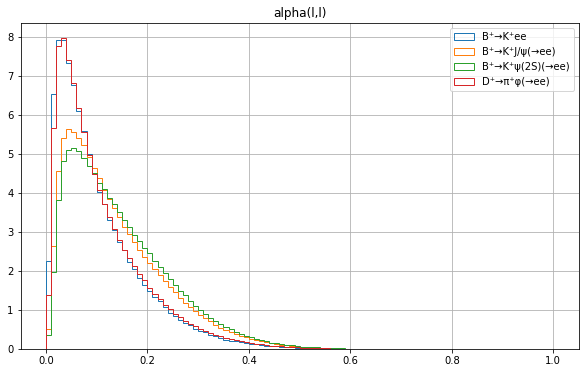

In [23]:
for idx in range(4):
    plt.hist(truthed[idx]['angle_ee_TRUE'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0, 1.0, 101), histtype='step')
plt.title('alpha(l,l)')
plt.legend()
plt.grid()
plt.show()

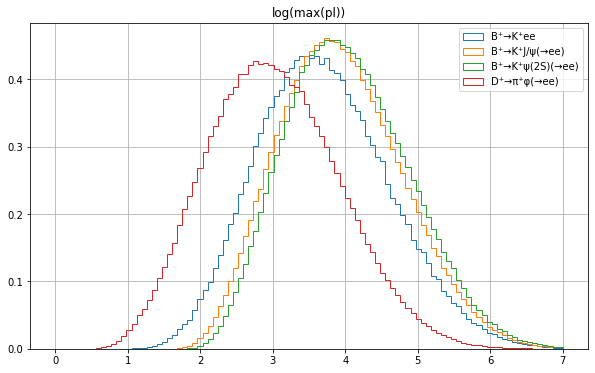

In [24]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['log_max_pl'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0, 7, 101), histtype='step')
plt.title(r'log(max(pl))')
plt.legend()
plt.grid()
plt.show()

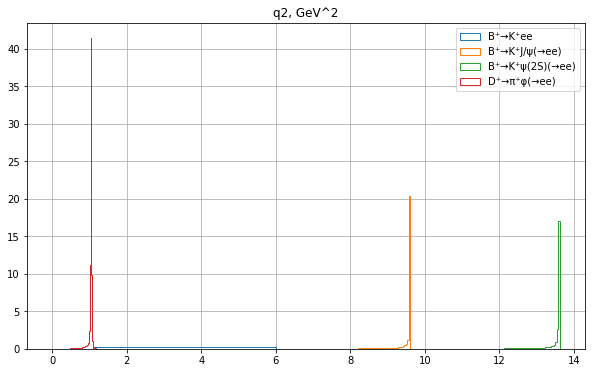

In [25]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['q2_TRUE'], label="%s"%df_index[idx],
             density=True, bins=100, histtype='step')
plt.title(r'q2, GeV^2')
plt.legend()
plt.grid()
plt.show()

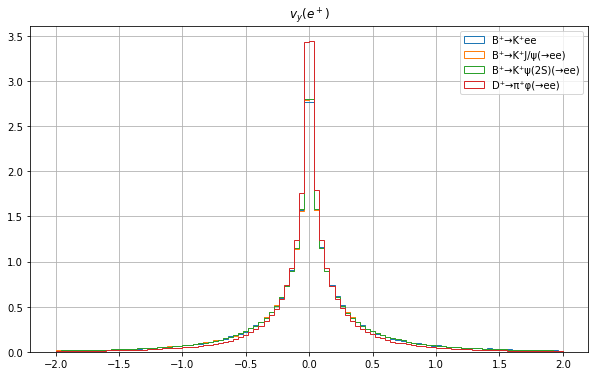

In [26]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['ep_origY_TRUE'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(-2,2,101), histtype='step')
plt.title(r'$v_y(e^+)$')
plt.legend()
plt.grid()
plt.show()

### Preprocessing

In [27]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [28]:
def make_dataset(fnames, idx):
    x = list()
    y = list()
    mapping = dict()
    for i, ix in enumerate(idx):
        try:
            x_ = np.hstack([truthed[ix][fn].reshape(-1, 1) for fn in fnames])
        except KeyError:
            x_ = np.ones((len(truthed[ix][list(truthed[ix].keys())[0]]), len(fnames))) * np.nan
        y_ = np.repeat(i, x_.shape[0])
        x.append(x_)
        y.append(y_)
        mapping[i] = ix
    X = np.vstack(x)
    Y = np.hstack(y)
    return X, Y, mapping

In [29]:
class Dataset():
    def __init__(self, features, idx):
        self.features = features
        self.indices = idx
        X, Y, mapping = make_dataset(features, idx)
        x_train, x_test, y_train, y_test = \
            sklearn.model_selection.train_test_split(X, Y, shuffle=True, stratify=Y, test_size=0.1)
        self.X = X
        self.Y = Y
        self.mapping = mapping
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(x_train)
        self.counts = np.asarray([np.sum(y_train==label) for label in sorted(mapping.keys())])
        self.weights = y_train.shape[0]/self.counts/self.counts.shape[0]
    def torch_dataset(self):
        dataset = torch.utils.data.TensorDataset(
            from_numpy(self.scaler.transform(self.x_train)),
            from_numpy(self.y_train, dtype=torch.long)
        )
        return dataset

In [30]:
def plot_ds(dataset):
    for label in sorted(dataset.mapping.keys()):
        idx = dataset.y_train==label
        x = dataset.x_train[idx][:10000,0:2]
        plt.scatter(*(x.T), marker=".", s=0.1, label="%s"%df_index[dataset.mapping[label]])
    #plt.gca().set_aspect('equal')
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.scaler.inverse_transform(-2*ones)[0,0:2]
    x_max, y_max = dataset.scaler.inverse_transform(2*ones)[0,0:2]
    plt.xlabel(dataset.features[0])
    plt.ylabel(dataset.features[1])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.plot()
    plt.legend()
    plt.grid()
    plt.show()

In [31]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

### NN

In [32]:
def model(inputs=2, outputs=4):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [33]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        total_count = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            count = x.shape[0]
            total_loss += loss
            total_count += count
            if not accumulate:
                loss /= count
                opt.zero_grad()
                loss.backward()
                opt.step()
        total_loss /= total_count
        if accumulate:
            opt.zero_grad()
            total_loss.backward()
            opt.step()
        logging.info("Epoch %d, %f", epoch, total_loss)
    model.eval()

### Weight limits estimation

In [34]:
def plot_field(f, dataset, name=None, save=None, vmin=0.0, vmax=1.0):
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.scaler.inverse_transform(-3*ones)[0,0:2]
    x_max, y_max = dataset.scaler.inverse_transform(3*ones)[0,0:2]
    X_test = np.random.rand(3000000, 2) * [x_max-x_min, y_max-y_min] + [x_min, y_min]
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    plt.colorbar()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(dataset.features[0])
    plt.ylabel(dataset.features[1])
    plt.grid()
    #plt.gca().set_aspect('equal')
    if name is not None:
        plt.title(name)
    if save is not None:
        plt.savefig(save)
    plt.show()

In [35]:
def plot_clf(ds, clf, c0, c1):
    fn = lambda x : x[:,c1] - x[:,c0]
    f = lambda x : to_numpy(torch.sigmoid(fn(clf(from_numpy(ds.scaler.transform(x))))))
    plot_field(f, ds, r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]]))

In [36]:
def plot_clf_min_max(ds, clf):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : to_numpy(torch.relu(torch.min(fn(clf(from_numpy(ds.scaler.transform(x)))), dim=-1)[0]))
    f_max = lambda x : to_numpy(torch.relu(torch.min(-fn(clf(from_numpy(ds.scaler.transform(x)))), dim=-1)[0]))
    plot_field(f_min, ds, r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$', vmax=None)
    plot_field(f_max, ds, r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$', vmax=None)

In [37]:
class Estimator():
    def __init__(self, features, idx):
        self.ds = Dataset(features, idx)
        self.model = model(len(features), len(list(idx))).to(device)
    def train(self):
        dataset = self.ds.torch_dataset()
        loader = Loader(dataset, batch_size=10000, shuffle=True, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=False)
        loader = Loader(dataset, batch_size=10000, shuffle=False, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=True)
        return self.model

In [38]:
e_a4 = Estimator(["alpha"], range(4))
e_a4.train()
e_a3 = Estimator(["alpha"], range(3))
e_a3.train()

INFO:root:Epoch 0, 1.369299
INFO:root:Epoch 1, 1.364723
INFO:root:Epoch 2, 1.364510
INFO:root:Epoch 3, 1.364352
INFO:root:Epoch 4, 1.364333
INFO:root:Epoch 5, 1.364269
INFO:root:Epoch 6, 1.364235
INFO:root:Epoch 7, 1.364140
INFO:root:Epoch 8, 1.364082
INFO:root:Epoch 9, 1.364080
INFO:root:Epoch 10, 1.363956
INFO:root:Epoch 11, 1.363910
INFO:root:Epoch 12, 1.363823
INFO:root:Epoch 13, 1.363777
INFO:root:Epoch 14, 1.363709
INFO:root:Epoch 15, 1.363626
INFO:root:Epoch 16, 1.363531
INFO:root:Epoch 17, 1.363465
INFO:root:Epoch 18, 1.363408
INFO:root:Epoch 19, 1.363320
INFO:root:Epoch 20, 1.363292
INFO:root:Epoch 21, 1.363252
INFO:root:Epoch 22, 1.363212
INFO:root:Epoch 23, 1.363217
INFO:root:Epoch 24, 1.363174
INFO:root:Epoch 25, 1.363154
INFO:root:Epoch 26, 1.363158
INFO:root:Epoch 27, 1.363153
INFO:root:Epoch 28, 1.363162
INFO:root:Epoch 29, 1.363129
INFO:root:Epoch 30, 1.363156
INFO:root:Epoch 31, 1.363145
INFO:root:Epoch 32, 1.363112
INFO:root:Epoch 33, 1.363138
INFO:root:Epoch 34, 1.36

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

In [39]:
e_la = Estimator(["alpha", "log_max_pl"], range(4))
e_la.train()

INFO:root:Epoch 0, 1.118256
INFO:root:Epoch 1, 0.892008
INFO:root:Epoch 2, 0.862683
INFO:root:Epoch 3, 0.844160
INFO:root:Epoch 4, 0.834859
INFO:root:Epoch 5, 0.827806
INFO:root:Epoch 6, 0.823186
INFO:root:Epoch 7, 0.820281
INFO:root:Epoch 8, 0.818091
INFO:root:Epoch 9, 0.816581
INFO:root:Epoch 10, 0.814966
INFO:root:Epoch 11, 0.814024
INFO:root:Epoch 12, 0.813062
INFO:root:Epoch 13, 0.812423
INFO:root:Epoch 14, 0.811968
INFO:root:Epoch 15, 0.811375
INFO:root:Epoch 16, 0.810924
INFO:root:Epoch 17, 0.810602
INFO:root:Epoch 18, 0.810286
INFO:root:Epoch 19, 0.810146
INFO:root:Epoch 20, 0.809917
INFO:root:Epoch 21, 0.809681
INFO:root:Epoch 22, 0.809450
INFO:root:Epoch 23, 0.809290
INFO:root:Epoch 24, 0.809139
INFO:root:Epoch 25, 0.809001
INFO:root:Epoch 26, 0.808865
INFO:root:Epoch 27, 0.808697
INFO:root:Epoch 28, 0.808634
INFO:root:Epoch 29, 0.808433
INFO:root:Epoch 30, 0.808397
INFO:root:Epoch 31, 0.808270
INFO:root:Epoch 32, 0.808183
INFO:root:Epoch 33, 0.808082
INFO:root:Epoch 34, 0.80

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

In [40]:
e_la3 = Estimator(["alpha", "log_max_pl"], range(3))
e_la3.train()

INFO:root:Epoch 0, 1.017182
INFO:root:Epoch 1, 0.883531
INFO:root:Epoch 2, 0.861101
INFO:root:Epoch 3, 0.838663
INFO:root:Epoch 4, 0.816837
INFO:root:Epoch 5, 0.804648
INFO:root:Epoch 6, 0.797732
INFO:root:Epoch 7, 0.792629
INFO:root:Epoch 8, 0.788693
INFO:root:Epoch 9, 0.785610
INFO:root:Epoch 10, 0.783316
INFO:root:Epoch 11, 0.781647
INFO:root:Epoch 12, 0.780445
INFO:root:Epoch 13, 0.779243
INFO:root:Epoch 14, 0.778517
INFO:root:Epoch 15, 0.777913
INFO:root:Epoch 16, 0.777538
INFO:root:Epoch 17, 0.777037
INFO:root:Epoch 18, 0.776838
INFO:root:Epoch 19, 0.776431
INFO:root:Epoch 20, 0.776227
INFO:root:Epoch 21, 0.776025
INFO:root:Epoch 22, 0.775854
INFO:root:Epoch 23, 0.775652
INFO:root:Epoch 24, 0.775512
INFO:root:Epoch 25, 0.775582
INFO:root:Epoch 26, 0.775329
INFO:root:Epoch 27, 0.775133
INFO:root:Epoch 28, 0.775062
INFO:root:Epoch 29, 0.774982
INFO:root:Epoch 30, 0.774851
INFO:root:Epoch 31, 0.774775
INFO:root:Epoch 32, 0.774620
INFO:root:Epoch 33, 0.774640
INFO:root:Epoch 34, 0.77

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

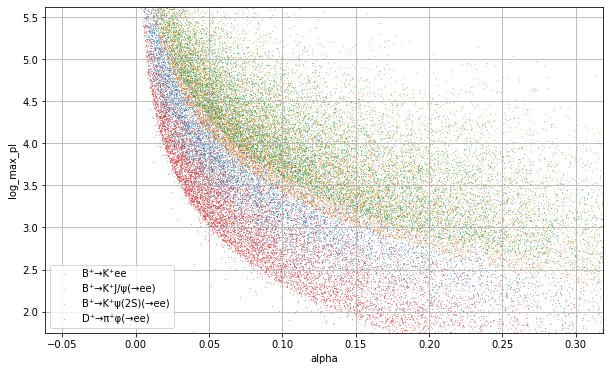

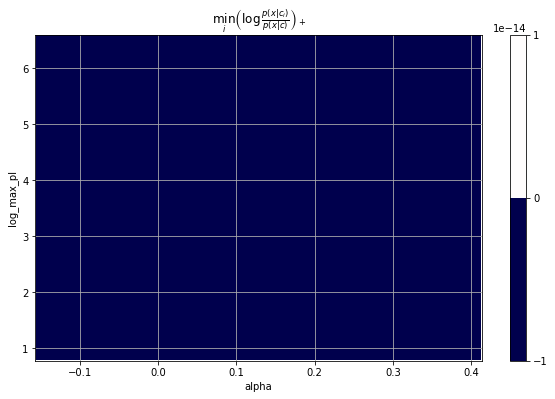

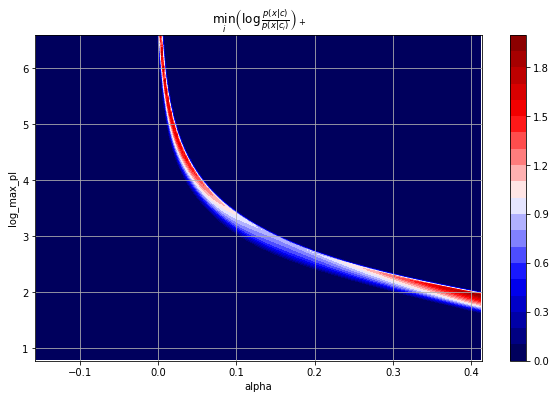

In [41]:
plot_ds(e_la.ds)
plot_clf_min_max(e_la.ds, e_la.model)

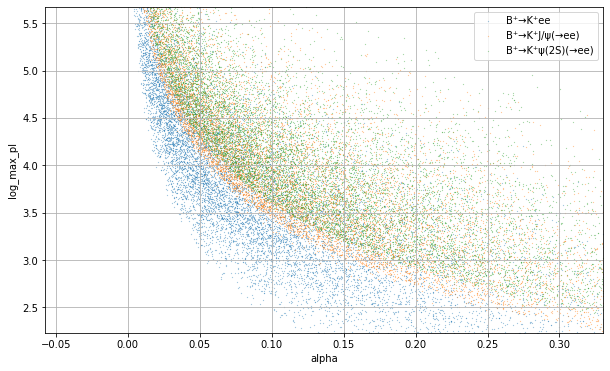

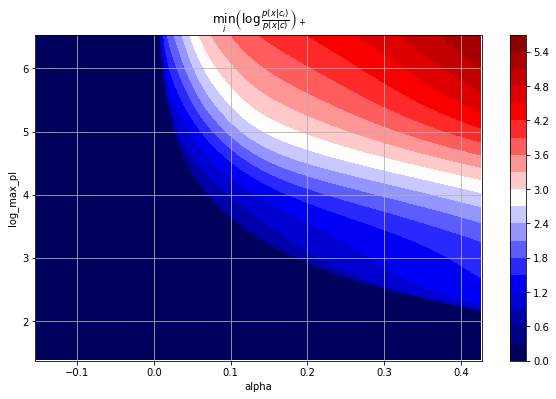

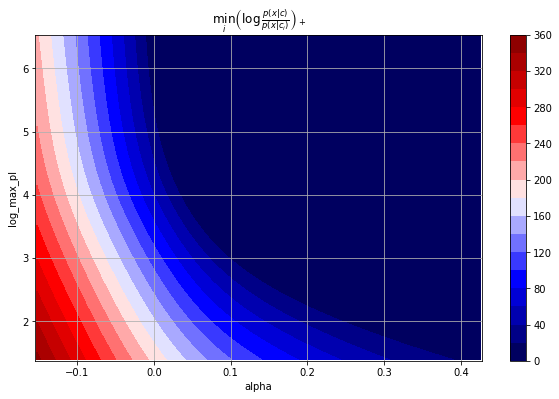

In [42]:
plot_ds(e_la3.ds)
plot_clf_min_max(e_la3.ds, e_la3.model)

In [43]:
e_ptpt = Estimator(["log_ep_PT", "log_em_PT"], range(4))
e_ptpt.train()

INFO:root:Epoch 0, 1.168596
INFO:root:Epoch 1, 1.057672
INFO:root:Epoch 2, 1.052395
INFO:root:Epoch 3, 1.049194
INFO:root:Epoch 4, 1.045901
INFO:root:Epoch 5, 1.043865
INFO:root:Epoch 6, 1.042889
INFO:root:Epoch 7, 1.042450
INFO:root:Epoch 8, 1.042121
INFO:root:Epoch 9, 1.041936
INFO:root:Epoch 10, 1.041747
INFO:root:Epoch 11, 1.041633
INFO:root:Epoch 12, 1.041555
INFO:root:Epoch 13, 1.041568
INFO:root:Epoch 14, 1.041411
INFO:root:Epoch 15, 1.041372
INFO:root:Epoch 16, 1.041350
INFO:root:Epoch 17, 1.041338
INFO:root:Epoch 18, 1.041417
INFO:root:Epoch 19, 1.041322
INFO:root:Epoch 20, 1.041310
INFO:root:Epoch 21, 1.041184
INFO:root:Epoch 22, 1.041222
INFO:root:Epoch 23, 1.041132
INFO:root:Epoch 24, 1.041133
INFO:root:Epoch 25, 1.041095
INFO:root:Epoch 26, 1.041109
INFO:root:Epoch 27, 1.041010
INFO:root:Epoch 28, 1.040996
INFO:root:Epoch 29, 1.041121
INFO:root:Epoch 30, 1.041003
INFO:root:Epoch 31, 1.040916
INFO:root:Epoch 32, 1.040971
INFO:root:Epoch 33, 1.040962
INFO:root:Epoch 34, 1.04

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

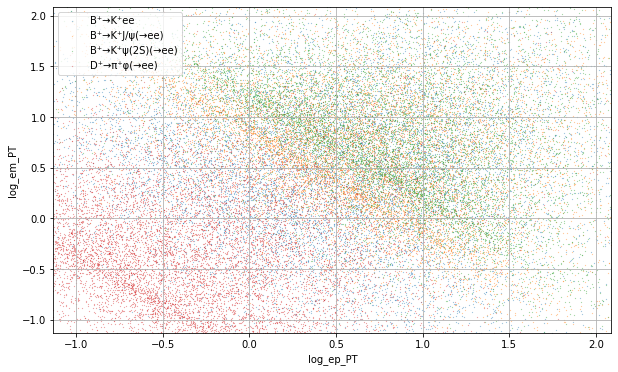

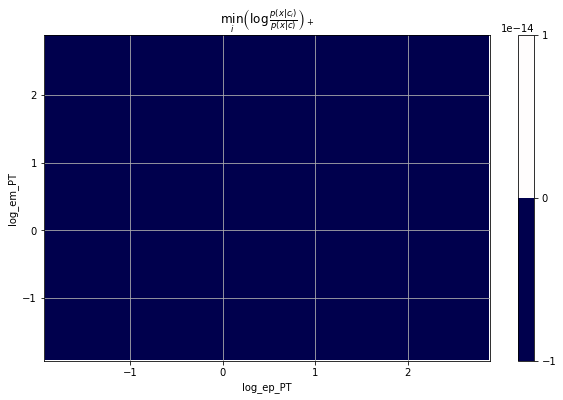

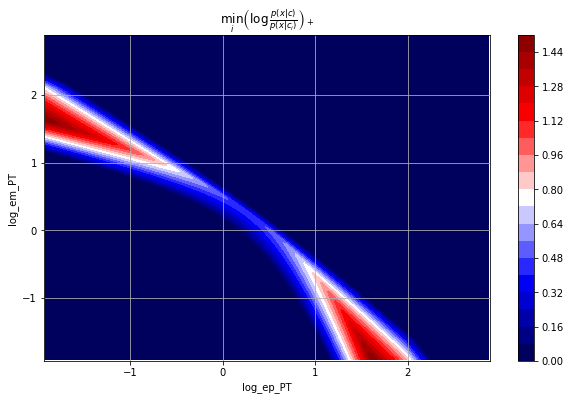

In [44]:
plot_ds(e_ptpt.ds)
plot_clf_min_max(e_ptpt.ds, e_ptpt.model)

In [45]:
e_ptpt3 = Estimator(["log_ep_PT", "log_em_PT"], range(3))
e_ptpt3.train()

INFO:root:Epoch 0, 1.087888
INFO:root:Epoch 1, 1.027993
INFO:root:Epoch 2, 1.006581
INFO:root:Epoch 3, 1.003818
INFO:root:Epoch 4, 1.001521
INFO:root:Epoch 5, 0.998824
INFO:root:Epoch 6, 0.995868
INFO:root:Epoch 7, 0.993522
INFO:root:Epoch 8, 0.992305
INFO:root:Epoch 9, 0.991578
INFO:root:Epoch 10, 0.991282
INFO:root:Epoch 11, 0.991165
INFO:root:Epoch 12, 0.990846
INFO:root:Epoch 13, 0.990769
INFO:root:Epoch 14, 0.990814
INFO:root:Epoch 15, 0.990681
INFO:root:Epoch 16, 0.990666
INFO:root:Epoch 17, 0.990646
INFO:root:Epoch 18, 0.990581
INFO:root:Epoch 19, 0.990539
INFO:root:Epoch 20, 0.990546
INFO:root:Epoch 21, 0.990554
INFO:root:Epoch 22, 0.990484
INFO:root:Epoch 23, 0.990501
INFO:root:Epoch 24, 0.990417
INFO:root:Epoch 25, 0.990501
INFO:root:Epoch 26, 0.990396
INFO:root:Epoch 27, 0.990405
INFO:root:Epoch 28, 0.990392
INFO:root:Epoch 29, 0.990370
INFO:root:Epoch 30, 0.990372
INFO:root:Epoch 31, 0.990328
INFO:root:Epoch 32, 0.990331
INFO:root:Epoch 33, 0.990260
INFO:root:Epoch 34, 0.99

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

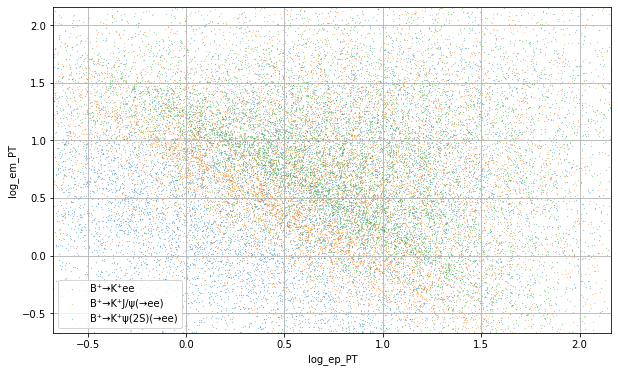

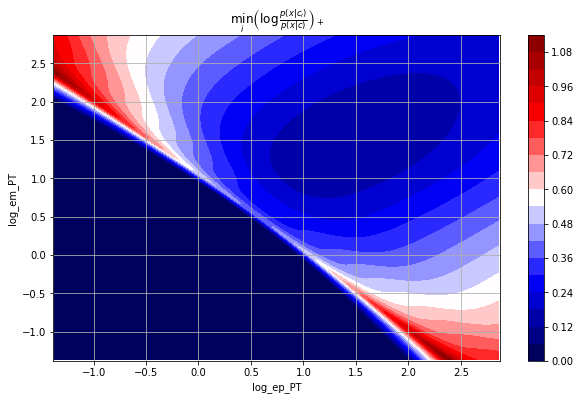

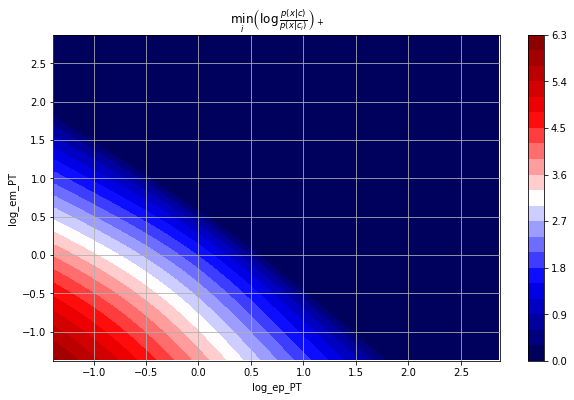

In [46]:
plot_ds(e_ptpt3.ds)
plot_clf_min_max(e_ptpt3.ds, e_ptpt3.model)

### Crafting a loss

In [47]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec, 0)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [48]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = torch.softmax(model(x), dim=1) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W

In [49]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    for epoch in range(epochs):
        W = create_w(model, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        det = np.linalg.det(W_np)
        W_pinv_ = from_numpy(W_pinv)
        
        wcj = W_pinv[selected_class]
        wcj_ = (wcj<0)
        wki = np.sum(W_pinv*wcj_[None,:], axis=1)
        W_m = np.multiply.outer(wcj, wki)
        W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
        #print(pred.shape, W.shape, W_pinv.shape)
        #print(W_pinv, w1j, wki, W_m)
        #print(ratio_estimator(w1j))
        #loss = torch.sum(W*from_numpy(W_m_))
        loss_c = torch.sum(W*from_numpy(W_m_))
        loss_d = -torch.sum(W*(W_pinv_.T))
        loss = loss_d + alpha * loss_c
        opt.zero_grad()
        loss.backward()
        opt.step()
        #logging.info("Epoch %d, loss=%f est=%f", epoch, loss, ratio_estimator(W_pinv[selected_class]))
        print("Epoch %d, loss=%f est=%f" % (epoch, loss, ratio_estimator(W_pinv[selected_class])),
              W_pinv[selected_class],
              det)
        #raise NotImplementedError
    model.eval()

In [50]:
@torch.no_grad()
def make_weighting(model, loader, selected_class, n_outs, n_classes):
    W = to_numpy(create_w(model, loader, n_outs, n_classes))
    print(W)
    print("|W| = ", np.linalg.det(W))
    Wpinv = np.linalg.pinv(W) # n*N
    print(Wpinv)
    w0 = Wpinv[selected_class]
    m_minus = np.max(-w0)
    m_plus = np.max(w0,0)
    m_sum = m_minus + m_plus
    linear = torch.nn.Linear(W.shape[0], 1, bias=False)
    linear.weight.data = from_numpy((w0 + m_minus)/m_sum)
    print(1/m_minus)
    print(linear.weight.data)
    return nn.Sequential(model, torch.nn.Softmax(dim=1), linear)

In [51]:
class Weighting():
    def __init__(self, estimator):
        N = len(list(estimator.ds.indices))
        self.estimator = estimator
        self.model = model(len(estimator.ds.features), N).to(device)
        self.model.load_state_dict(estimator.model.state_dict())
        self.n_outs = N
        self.n_classes = N
    def train(self):
        self.w_model_ = None
        loader = Loader(self.estimator.ds.torch_dataset(), batch_size=10000, shuffle=False, device=device)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, 0, epochs=200, alpha=0.001)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, 0, epochs=500, alpha=300)
        return self.w_model()
    def w_model(self):
        if self.w_model_ is None:
            loader = Loader(self.estimator.ds.torch_dataset(), batch_size=10000, shuffle=False, device=device)
            self.w_model_ = make_weighting(self.model, loader, 0, self.n_outs, self.n_classes)
        return self.w_model_
    def w_model_np(self):
        fn = self.w_model()
        fn_np = lambda x : to_numpy(fn(from_numpy(self.estimator.ds.scaler.transform(x))))
        return fn_np
    def dataset(self):
        return self.estimator.ds

In [52]:
w_la = Weighting(e_la)
w_la.train()

Epoch 0, loss=-4.000087 est=0.318643 [ 4.3147 -3.1383  1.3173 -1.4752] 0.00875583
Epoch 1, loss=-4.000086 est=0.350382 [ 4.3142 -2.854   1.084  -1.4017] 0.009815658
Epoch 2, loss=-4.000085 est=0.379063 [ 4.3168 -2.6381  0.9159 -1.3332] 0.010875052
Epoch 3, loss=-4.000084 est=0.414939 [ 4.2899 -2.41    0.7592 -1.3028] 0.0119620375
Epoch 4, loss=-4.000084 est=0.459232 [ 4.2327 -2.1776  0.6177 -1.3042] 0.013082825
Epoch 5, loss=-4.000085 est=0.510248 [ 4.1566 -1.9598  0.4989 -1.3243] 0.014223233
Epoch 6, loss=-4.000086 est=0.565769 [ 4.0721 -1.7675  0.4043 -1.3517] 0.01536855
Epoch 7, loss=-4.000087 est=0.623949 [ 3.9869 -1.6027  0.3311 -1.3776] 0.016511288
Epoch 8, loss=-4.000088 est=0.683982 [ 3.9066 -1.462   0.2742 -1.3967] 0.017649323
Epoch 9, loss=-4.000089 est=0.710973 [ 3.8344 -1.3408  0.2292 -1.4065] 0.018782143
Epoch 10, loss=-4.000089 est=0.710746 [ 3.7709 -1.2353  0.193  -1.407 ] 0.019907549
Epoch 11, loss=-4.000090 est=0.714436 [ 3.7152 -1.1428  0.1635 -1.3997] 0.021021342
Epo

Epoch 99, loss=-4.000093 est=0.944135 [ 2.525  -0.187   0.02   -1.0592] 0.051632725
Epoch 100, loss=-4.000093 est=0.944623 [ 2.5241 -0.1863  0.0199 -1.0586] 0.051678546
Epoch 101, loss=-4.000093 est=0.945085 [ 2.5232 -0.1856  0.0198 -1.0581] 0.051723212
Epoch 102, loss=-4.000093 est=0.945522 [ 2.5223 -0.185   0.0198 -1.0576] 0.051766835
Epoch 103, loss=-4.000093 est=0.945942 [ 2.5214 -0.1843  0.0197 -1.0571] 0.05180937
Epoch 104, loss=-4.000093 est=0.946341 [ 2.5206 -0.1837  0.0196 -1.0567] 0.05185099
Epoch 105, loss=-4.000093 est=0.946714 [ 2.5197 -0.1831  0.0196 -1.0563] 0.05189157
Epoch 106, loss=-4.000093 est=0.947065 [ 2.5189 -0.1825  0.0195 -1.0559] 0.051931374
Epoch 107, loss=-4.000093 est=0.947403 [ 2.5181 -0.1818  0.0194 -1.0555] 0.051970307
Epoch 108, loss=-4.000093 est=0.947743 [ 2.5173 -0.1813  0.0194 -1.0551] 0.052008417
Epoch 109, loss=-4.000093 est=0.948089 [ 2.5165 -0.1807  0.0193 -1.0548] 0.0520457
Epoch 110, loss=-4.000093 est=0.948440 [ 2.5158 -0.1801  0.0192 -1.0544

Epoch 196, loss=-4.000092 est=0.971269 [ 2.4794 -0.1568  0.0151 -1.0296] 0.053952944
Epoch 197, loss=-4.000092 est=0.971457 [ 2.4791 -0.1567  0.015  -1.0294] 0.053967386
Epoch 198, loss=-4.000092 est=0.971645 [ 2.4788 -0.1565  0.015  -1.0292] 0.053981718
Epoch 199, loss=-4.000092 est=0.971829 [ 2.4785 -0.1564  0.015  -1.029 ] 0.053995945
Epoch 0, loss=-31.413368 est=0.972014 [ 2.4782 -0.1562  0.0149 -1.0288] 0.054010138
Epoch 1, loss=-28.327625 est=1.079057 [ 2.6054 -0.1604  0.0163 -0.9267] 0.05367121
Epoch 2, loss=-25.609591 est=1.161161 [ 2.7583 -0.1456  0.0151 -0.8612] 0.052750427
Epoch 3, loss=-23.233595 est=1.252617 [ 2.9343 -0.1431  0.0154 -0.7983] 0.0512869
Epoch 4, loss=-21.170570 est=1.343552 [ 3.1391 -0.145   0.0162 -0.7443] 0.049358983
Epoch 5, loss=-19.390488 est=1.420203 [ 3.3753 -0.145   0.0167 -0.7041] 0.047071733
Epoch 6, loss=-17.868063 est=1.477052 [ 3.6364 -0.1414  0.0165 -0.677 ] 0.044624485
Epoch 7, loss=-16.580700 est=1.518916 [ 3.9142 -0.1369  0.0161 -0.6584] 0.0

Epoch 93, loss=-8.879704 est=2.130687 [ 7.8345 -0.0862  0.0187 -0.4693] 0.022654388
Epoch 94, loss=-8.780865 est=2.142816 [ 7.9562 -0.0859  0.0185 -0.4667] 0.022336928
Epoch 95, loss=-8.682046 est=2.154646 [ 8.0815 -0.0854  0.0183 -0.4641] 0.022019342
Epoch 96, loss=-8.583318 est=2.166120 [ 8.2105 -0.0847  0.0181 -0.4617] 0.021701794
Epoch 97, loss=-8.485014 est=2.177866 [ 8.3432 -0.0839  0.0179 -0.4592] 0.021384614
Epoch 98, loss=-8.387436 est=2.190558 [ 8.4794 -0.0833  0.0176 -0.4565] 0.02106809
Epoch 99, loss=-8.290678 est=2.204250 [ 8.6193 -0.0827  0.0174 -0.4537] 0.020752136
Epoch 100, loss=-8.194655 est=2.218338 [ 8.7635 -0.0822  0.0172 -0.4508] 0.02043617
Epoch 101, loss=-8.099318 est=2.232151 [ 8.9124 -0.0815  0.017  -0.448 ] 0.020119935
Epoch 102, loss=-8.005023 est=2.245627 [ 9.0657 -0.0808  0.0168 -0.4453] 0.019804284
Epoch 103, loss=-7.912460 est=2.259342 [ 9.2226 -0.08    0.0165 -0.4426] 0.019491252
Epoch 104, loss=-7.822378 est=2.273830 [ 9.3818 -0.0794  0.0163 -0.4398] 0

Epoch 190, loss=-7.194800 est=2.466479 [10.2295 -0.073   0.0115 -0.4054] 0.01804311
Epoch 191, loss=-7.196368 est=2.466064 [10.2222 -0.0729  0.0114 -0.4055] 0.018056398
Epoch 192, loss=-7.197735 est=2.465694 [10.2155 -0.0728  0.0114 -0.4056] 0.018068656
Epoch 193, loss=-7.198968 est=2.465357 [10.2092 -0.0726  0.0114 -0.4056] 0.0180802
Epoch 194, loss=-7.200206 est=2.465073 [10.2029 -0.0725  0.0113 -0.4057] 0.018091755
Epoch 195, loss=-7.201560 est=2.464843 [10.1963 -0.0724  0.0113 -0.4057] 0.018103788
Epoch 196, loss=-7.203031 est=2.464665 [10.1895 -0.0723  0.0113 -0.4057] 0.018116303
Epoch 197, loss=-7.204504 est=2.464547 [10.1827 -0.0723  0.0112 -0.4058] 0.018128866
Epoch 198, loss=-7.205861 est=2.464536 [10.1762 -0.0722  0.0112 -0.4058] 0.018140912
Epoch 199, loss=-7.206964 est=2.464660 [10.1704 -0.0721  0.0112 -0.4057] 0.018151805
Epoch 200, loss=-7.207772 est=2.464907 [10.1655 -0.0721  0.0112 -0.4057] 0.018161321
Epoch 201, loss=-7.208336 est=2.465251 [10.1611 -0.0721  0.0112 -0.4

Epoch 287, loss=-7.146774 est=2.494664 [10.1179 -0.0688  0.0092 -0.4009] 0.018394683
Epoch 288, loss=-7.146436 est=2.494911 [10.1175 -0.0687  0.0092 -0.4008] 0.018395893
Epoch 289, loss=-7.146093 est=2.495153 [10.1172 -0.0687  0.0092 -0.4008] 0.018396847
Epoch 290, loss=-7.145733 est=2.495409 [10.117  -0.0686  0.0092 -0.4007] 0.0183976
Epoch 291, loss=-7.145349 est=2.495680 [10.1169 -0.0686  0.0092 -0.4007] 0.018398054
Epoch 292, loss=-7.144945 est=2.495955 [10.1169 -0.0686  0.0092 -0.4006] 0.018398248
Epoch 293, loss=-7.144502 est=2.496240 [10.117  -0.0685  0.0092 -0.4006] 0.018398175
Epoch 294, loss=-7.144035 est=2.496544 [10.1172 -0.0685  0.0092 -0.4006] 0.018397855
Epoch 295, loss=-7.143534 est=2.496845 [10.1175 -0.0684  0.0092 -0.4005] 0.018397292
Epoch 296, loss=-7.142990 est=2.497170 [10.118  -0.0684  0.0092 -0.4005] 0.018396497
Epoch 297, loss=-7.142421 est=2.497498 [10.1186 -0.0684  0.0092 -0.4004] 0.01839548
Epoch 298, loss=-7.141794 est=2.497837 [10.1192 -0.0683  0.0092 -0.4

Epoch 384, loss=-7.087499 est=2.530773 [10.1809 -0.0658  0.009  -0.3951] 0.018285977
Epoch 385, loss=-7.085944 est=2.528025 [10.1837 -0.0652  0.0089 -0.3956] 0.018281078
Epoch 386, loss=-7.085918 est=2.529685 [10.1831 -0.0654  0.009  -0.3953] 0.018282326
Epoch 387, loss=-7.085800 est=2.530779 [10.1826 -0.0655  0.009  -0.3951] 0.01828327
Epoch 388, loss=-7.084573 est=2.528675 [10.1846 -0.0651  0.0089 -0.3955] 0.01827982
Epoch 389, loss=-7.084433 est=2.532278 [10.1844 -0.0656  0.009  -0.3949] 0.018280331
Epoch 390, loss=-7.082478 est=2.529982 [10.1883 -0.0651  0.0089 -0.3953] 0.018273752
Epoch 391, loss=-7.081650 est=2.532107 [10.1897 -0.0654  0.009  -0.3949] 0.01827148
Epoch 392, loss=-7.080622 est=2.532482 [10.1915 -0.0653  0.009  -0.3949] 0.018268537
Epoch 393, loss=-7.079627 est=2.531491 [10.1931 -0.0651  0.0089 -0.395 ] 0.018265901
Epoch 394, loss=-7.079836 est=2.534066 [10.1919 -0.0654  0.009  -0.3946] 0.018268095
Epoch 395, loss=-7.078903 est=2.531822 [10.1932 -0.065   0.0089 -0.3

Epoch 481, loss=-7.042886 est=2.557828 [10.2243 -0.0634  0.0089 -0.391 ] 0.018215213
Epoch 482, loss=-7.043851 est=2.562803 [10.2217 -0.0641  0.009  -0.3902] 0.018219825
Epoch 483, loss=-7.042069 est=2.557643 [10.2251 -0.0632  0.0089 -0.391 ] 0.018213864
Epoch 484, loss=-7.043479 est=2.564209 [10.2216 -0.0642  0.009  -0.39  ] 0.018220173
Epoch 485, loss=-7.041157 est=2.557053 [10.2262 -0.063   0.0088 -0.3911] 0.018212005
Epoch 486, loss=-7.043209 est=2.566094 [10.2213 -0.0644  0.0091 -0.3897] 0.018220773
Epoch 487, loss=-7.040035 est=2.555855 [10.2278 -0.0627  0.0088 -0.3913] 0.018209253
Epoch 488, loss=-7.043118 est=2.568589 [10.2207 -0.0647  0.0091 -0.3893] 0.018221924
Epoch 489, loss=-7.038800 est=2.553972 [10.2298 -0.0623  0.0087 -0.3915] 0.01820594
Epoch 490, loss=-7.043259 est=2.571421 [10.2197 -0.0651  0.0092 -0.3889] 0.018223824
Epoch 491, loss=-7.037679 est=2.552079 [10.2315 -0.062   0.0087 -0.3918] 0.018203039
Epoch 492, loss=-7.043200 est=2.573353 [10.219  -0.0653  0.0092 -0

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=4, out_features=1, bias=False)
)

In [53]:
w_la3 = Weighting(e_la3)
w_la3.train()

Epoch 0, loss=-3.000084 est=0.699854 [ 1.7852 -1.4289  0.6439] 0.031911355
Epoch 1, loss=-3.000079 est=0.794483 [ 1.7949 -1.2587  0.5158] 0.03489201
Epoch 2, loss=-3.000073 est=0.896471 [ 1.8031 -1.1155  0.4141] 0.03788733
Epoch 3, loss=-3.000070 est=1.008727 [ 1.8116 -0.9913  0.3308] 0.040869262
Epoch 4, loss=-3.000066 est=1.132866 [ 1.8207 -0.8827  0.2621] 0.04380827
Epoch 5, loss=-3.000062 est=1.270238 [ 1.8307 -0.7873  0.2054] 0.04667726
Epoch 6, loss=-3.000057 est=1.421403 [ 1.8412 -0.7035  0.159 ] 0.049453214
Epoch 7, loss=-3.000054 est=1.585993 [ 1.852  -0.6305  0.1216] 0.052117895
Epoch 8, loss=-3.000051 est=1.762927 [ 1.8626 -0.5672  0.0919] 0.054659527
Epoch 9, loss=-3.000046 est=1.950449 [ 1.8724 -0.5127  0.0686] 0.057071928
Epoch 10, loss=-3.000044 est=2.146168 [ 1.8812 -0.4659  0.0507] 0.059354525
Epoch 11, loss=-3.000041 est=2.347256 [ 1.8888 -0.426   0.0373] 0.061511215
Epoch 12, loss=-3.000038 est=2.550869 [ 1.8949 -0.392   0.0274] 0.06354905
Epoch 13, loss=-3.000036 es

Epoch 109, loss=-3.000013 est=9.310202 [ 1.8104 -0.1074  0.0112] 0.10803291
Epoch 110, loss=-3.000012 est=9.331791 [ 1.8099 -0.1072  0.0111] 0.10809876
Epoch 111, loss=-3.000013 est=9.352146 [ 1.8094 -0.1069  0.0111] 0.108163446
Epoch 112, loss=-3.000012 est=9.372118 [ 1.8089 -0.1067  0.0111] 0.10822699
Epoch 113, loss=-3.000012 est=9.392623 [ 1.8084 -0.1065  0.011 ] 0.1082896
Epoch 114, loss=-3.000013 est=9.413757 [ 1.808  -0.1062  0.011 ] 0.10835082
Epoch 115, loss=-3.000013 est=9.435084 [ 1.8075 -0.106   0.011 ] 0.10841135
Epoch 116, loss=-3.000013 est=9.456449 [ 1.8071 -0.1057  0.0109] 0.10847062
Epoch 117, loss=-3.000013 est=9.478230 [ 1.8067 -0.1055  0.0109] 0.108528994
Epoch 118, loss=-3.000013 est=9.500512 [ 1.8063 -0.1053  0.0109] 0.10858639
Epoch 119, loss=-3.000012 est=9.522621 [ 1.8059 -0.105   0.0109] 0.108642995
Epoch 120, loss=-3.000012 est=9.543924 [ 1.8055 -0.1048  0.0108] 0.108698525
Epoch 121, loss=-3.000012 est=9.564556 [ 1.8051 -0.1046  0.0108] 0.10875332
Epoch 122

Epoch 17, loss=-3.128035 est=180.237377 [ 2.7302 -0.0055  0.0002] 0.07347836
Epoch 18, loss=-3.115904 est=198.050052 [ 2.756  -0.005   0.0002] 0.072908066
Epoch 19, loss=-3.105678 est=216.407605 [ 2.7788 -0.0046  0.0002] 0.072438896
Epoch 20, loss=-3.097109 est=234.981596 [ 2.7987 -0.0043  0.0002] 0.07205972
Epoch 21, loss=-3.089939 est=253.455238 [ 2.8156 -0.0039  0.0002] 0.071760915
Epoch 22, loss=-3.083997 est=271.414502 [ 2.8297 -0.0037  0.0002] 0.07153437
Epoch 23, loss=-3.079127 est=288.456656 [ 2.8412 -0.0035  0.0002] 0.0713732
Epoch 24, loss=-3.075182 est=304.221658 [ 2.85   -0.0033  0.0002] 0.071271285
Epoch 25, loss=-3.072053 est=318.365327 [ 2.8565 -0.0031  0.0002] 0.07122334
Epoch 26, loss=-3.069624 est=330.663723 [ 2.8607 -0.003   0.0002] 0.07122434
Epoch 27, loss=-3.067829 est=340.889467 [ 2.8627 -0.0029  0.0002] 0.071270056
Epoch 28, loss=-3.066571 est=349.001831 [ 2.8626 -0.0029  0.0002] 0.071356244
Epoch 29, loss=-3.065828 est=354.878078 [ 2.8607 -0.0028  0.0002] 0.071

Epoch 123, loss=-3.093626 est=303.869014 [ 2.4724 -0.0033  0.0004] 0.08365263
Epoch 124, loss=-3.093323 est=304.674681 [ 2.4728 -0.0033  0.0004] 0.08366068
Epoch 125, loss=-3.092978 est=305.573656 [ 2.4733 -0.0033  0.0004] 0.08366694
Epoch 126, loss=-3.092662 est=306.433169 [ 2.4737 -0.0033  0.0004] 0.083672576
Epoch 127, loss=-3.092337 est=307.297531 [ 2.4741 -0.0033  0.0004] 0.08367851
Epoch 128, loss=-3.092037 est=308.098872 [ 2.4745 -0.0032  0.0004] 0.08368553
Epoch 129, loss=-3.091782 est=308.790694 [ 2.4748 -0.0032  0.0004] 0.08369435
Epoch 130, loss=-3.091528 est=309.439965 [ 2.475  -0.0032  0.0004] 0.083705194
Epoch 131, loss=-3.091347 est=309.920124 [ 2.4751 -0.0032  0.0004] 0.08371831
Epoch 132, loss=-3.091190 est=310.309918 [ 2.4752 -0.0032  0.0004] 0.083733864
Epoch 133, loss=-3.091048 est=310.631661 [ 2.4751 -0.0032  0.0004] 0.08375144
Epoch 134, loss=-3.090969 est=310.804298 [ 2.475  -0.0032  0.0004] 0.08377101
Epoch 135, loss=-3.090905 est=310.919496 [ 2.4748 -0.0032  0.

Epoch 228, loss=-3.081978 est=340.764837 [ 2.4741 -0.0029  0.0003] 0.084563866
Epoch 229, loss=-3.081905 est=341.041916 [ 2.4741 -0.0029  0.0003] 0.084568985
Epoch 230, loss=-3.081851 est=341.277787 [ 2.4741 -0.0029  0.0003] 0.08457427
Epoch 231, loss=-3.081788 est=341.527889 [ 2.474  -0.0029  0.0003] 0.084579706
Epoch 232, loss=-3.081744 est=341.736587 [ 2.474  -0.0029  0.0003] 0.08458524
Epoch 233, loss=-3.081680 est=341.987362 [ 2.4739 -0.0029  0.0003] 0.08459076
Epoch 234, loss=-3.081642 est=342.182664 [ 2.4739 -0.0029  0.0003] 0.08459636
Epoch 235, loss=-3.081572 est=342.448073 [ 2.4739 -0.0029  0.0003] 0.08460169
Epoch 236, loss=-3.081537 est=342.643902 [ 2.4738 -0.0029  0.0003] 0.08460699
Epoch 237, loss=-3.081472 est=342.910027 [ 2.4738 -0.0029  0.0003] 0.08461186
Epoch 238, loss=-3.081416 est=343.162528 [ 2.4738 -0.0029  0.0003] 0.08461663
Epoch 239, loss=-3.081354 est=343.429460 [ 2.4738 -0.0029  0.0003] 0.08462113
Epoch 240, loss=-3.081288 est=343.710891 [ 2.4737 -0.0029  0.

Epoch 333, loss=-3.076996 est=365.166638 [ 2.4711 -0.0027  0.0003] 0.08496175
Epoch 334, loss=-3.076956 est=365.373405 [ 2.4711 -0.0027  0.0003] 0.084964305
Epoch 335, loss=-3.076921 est=365.564475 [ 2.4711 -0.0027  0.0003] 0.08496671
Epoch 336, loss=-3.076893 est=365.739798 [ 2.471  -0.0027  0.0003] 0.08496938
Epoch 337, loss=-3.076845 est=365.963179 [ 2.471  -0.0027  0.0003] 0.0849718
Epoch 338, loss=-3.076803 est=366.170850 [ 2.471  -0.0027  0.0003] 0.08497426
Epoch 339, loss=-3.076768 est=366.362755 [ 2.471  -0.0027  0.0003] 0.08497661
Epoch 340, loss=-3.076746 est=366.522830 [ 2.4709 -0.0027  0.0003] 0.08497907
Epoch 341, loss=-3.076697 est=366.747169 [ 2.4709 -0.0027  0.0003] 0.08498142
Epoch 342, loss=-3.076668 est=366.923629 [ 2.4709 -0.0027  0.0003] 0.08498388
Epoch 343, loss=-3.076631 est=367.116324 [ 2.4708 -0.0027  0.0003] 0.08498632
Epoch 344, loss=-3.076607 est=367.277058 [ 2.4708 -0.0027  0.0003] 0.084988594
Epoch 345, loss=-3.076564 est=367.486222 [ 2.4708 -0.0027  0.00

Epoch 438, loss=-3.074006 est=381.734152 [ 2.4676 -0.0026  0.0003] 0.08518597
Epoch 439, loss=-3.074006 est=381.803650 [ 2.4675 -0.0026  0.0003] 0.085187994
Epoch 440, loss=-3.073959 est=381.994900 [ 2.4675 -0.0026  0.0003] 0.08519001
Epoch 441, loss=-3.073952 est=382.081895 [ 2.4675 -0.0026  0.0003] 0.085192
Epoch 442, loss=-3.073924 est=382.221169 [ 2.4674 -0.0026  0.0003] 0.085194156
Epoch 443, loss=-3.073897 est=382.360545 [ 2.4674 -0.0026  0.0003] 0.08519631
Epoch 444, loss=-3.073882 est=382.465144 [ 2.4673 -0.0026  0.0003] 0.0851984
Epoch 445, loss=-3.073868 est=382.569800 [ 2.4673 -0.0026  0.0003] 0.085200265
Epoch 446, loss=-3.073840 est=382.709430 [ 2.4673 -0.0026  0.0003] 0.08520243
Epoch 447, loss=-3.073819 est=382.831690 [ 2.4672 -0.0026  0.0003] 0.08520451
Epoch 448, loss=-3.073798 est=382.954029 [ 2.4672 -0.0026  0.0003] 0.08520658
Epoch 449, loss=-3.073776 est=383.076445 [ 2.4671 -0.0026  0.0003] 0.08520865
Epoch 450, loss=-3.073754 est=383.198940 [ 2.4671 -0.0026  0.000

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

In [54]:
w_ptpt = Weighting(e_ptpt)
w_ptpt.train()

Epoch 0, loss=-4.000069 est=0.106521 [14.3554 -9.3878 -0.7193 -3.3069] 0.0013613187
Epoch 1, loss=-4.000077 est=0.119017 [12.918  -8.4022 -0.6159 -3.6481] 0.0015802126
Epoch 2, loss=-4.000086 est=0.132045 [11.726  -7.5732 -0.5213 -4.0281] 0.0017937132
Epoch 3, loss=-4.000093 est=0.145402 [10.7771 -6.8775 -0.4469 -4.4292] 0.0019941593
Epoch 4, loss=-4.000099 est=0.158386 [10.0545 -6.3137 -0.3956 -4.7973] 0.002180322
Epoch 5, loss=-4.000104 est=0.170225 [ 9.5233 -5.8746 -0.364  -5.0664] 0.0023587078
Epoch 6, loss=-4.000109 est=0.180576 [ 9.143  -5.5378 -0.3482 -5.2   ] 0.002538392
Epoch 7, loss=-4.000113 est=0.189415 [ 8.8761 -5.2794 -0.3439 -5.1993] 0.0027257209
Epoch 8, loss=-4.000115 est=0.196466 [ 8.6923 -5.08   -0.3468 -5.0899] 0.0029229708
Epoch 9, loss=-4.000117 est=0.203042 [ 8.5663 -4.9251 -0.3521 -4.9078] 0.0031293917
Epoch 10, loss=-4.000118 est=0.208155 [ 8.476  -4.8041 -0.3554 -4.688 ] 0.0033427621
Epoch 11, loss=-4.000119 est=0.212409 [ 8.4029 -4.7079 -0.3536 -4.4586] 0.003

Epoch 98, loss=-4.000133 est=0.424039 [ 4.8504 -1.7545  0.0769 -2.3583] 0.01774701
Epoch 99, loss=-4.000133 est=0.424512 [ 4.8445 -1.7499  0.0764 -2.3556] 0.017795824
Epoch 100, loss=-4.000133 est=0.424974 [ 4.8386 -1.7455  0.076  -2.3531] 0.0178435
Epoch 101, loss=-4.000134 est=0.425435 [ 4.8328 -1.7413  0.0756 -2.3505] 0.017890071
Epoch 102, loss=-4.000133 est=0.425906 [ 4.8272 -1.7373  0.0752 -2.3479] 0.01793562
Epoch 103, loss=-4.000133 est=0.426392 [ 4.8218 -1.7334  0.0748 -2.3453] 0.01798013
Epoch 104, loss=-4.000133 est=0.426899 [ 4.8166 -1.7297  0.0745 -2.3425] 0.018023632
Epoch 105, loss=-4.000134 est=0.427427 [ 4.8117 -1.7261  0.0741 -2.3396] 0.018066183
Epoch 106, loss=-4.000133 est=0.427974 [ 4.807  -1.7227  0.0738 -2.3366] 0.018107792
Epoch 107, loss=-4.000134 est=0.428533 [ 4.8025 -1.7194  0.0735 -2.3335] 0.018148534
Epoch 108, loss=-4.000134 est=0.429097 [ 4.7981 -1.7161  0.0732 -2.3305] 0.018188382
Epoch 109, loss=-4.000134 est=0.429660 [ 4.7939 -1.713   0.0729 -2.3274]

Epoch 195, loss=-4.000137 est=0.452988 [ 4.5864 -1.5797  0.0591 -2.2076] 0.019964162
Epoch 196, loss=-4.000137 est=0.453139 [ 4.5851 -1.579   0.059  -2.2068] 0.019974735
Epoch 197, loss=-4.000137 est=0.453288 [ 4.5838 -1.5783  0.0589 -2.2061] 0.019985184
Epoch 198, loss=-4.000137 est=0.453436 [ 4.5825 -1.5776  0.0588 -2.2054] 0.019995531
Epoch 199, loss=-4.000137 est=0.453583 [ 4.5812 -1.5769  0.0587 -2.2047] 0.020005781
Epoch 0, loss=-45.244537 est=0.453729 [ 4.58   -1.5763  0.0586 -2.204 ] 0.020015944
Epoch 1, loss=-41.331638 est=0.501106 [ 4.9018 -1.5667  0.0686 -1.9956] 0.01985853
Epoch 2, loss=-37.852959 est=0.543741 [ 5.2689 -1.5512  0.0777 -1.8391] 0.019426692
Epoch 3, loss=-34.738411 est=0.580631 [ 5.6821 -1.5288  0.0855 -1.7223] 0.018793834
Epoch 4, loss=-31.930433 est=0.611563 [ 6.1436 -1.5004  0.092  -1.6352] 0.0180209
Epoch 5, loss=-29.384895 est=0.636683 [ 6.6566 -1.4672  0.0972 -1.5706] 0.017155696
Epoch 6, loss=-27.066765 est=0.656384 [ 7.2261 -1.4301  0.1012 -1.5235] 0.

Epoch 92, loss=-15.445674 est=0.702892 [13.4847 -1.1285  0.0847 -1.4227] 0.010035536
Epoch 93, loss=-15.441678 est=0.703391 [13.4875 -1.1285  0.085  -1.4217] 0.010032274
Epoch 94, loss=-15.431257 est=0.703938 [13.4975 -1.1285  0.0853 -1.4206] 0.010023826
Epoch 95, loss=-15.414033 est=0.704527 [13.5152 -1.1285  0.0857 -1.4194] 0.010009996
Epoch 96, loss=-15.389724 est=0.705152 [13.541  -1.1284  0.0861 -1.4181] 0.009990715
Epoch 97, loss=-15.358181 est=0.705807 [13.575  -1.1282  0.0865 -1.4168] 0.009965963
Epoch 98, loss=-15.319405 est=0.706490 [13.6175 -1.1279  0.087  -1.4154] 0.009935875
Epoch 99, loss=-15.273725 est=0.707190 [13.6683 -1.1276  0.0874 -1.414 ] 0.009900773
Epoch 100, loss=-15.221853 est=0.707904 [13.7266 -1.1272  0.0877 -1.4126] 0.0098613305
Epoch 101, loss=-15.165062 est=0.708621 [13.7912 -1.1268  0.088  -1.4112] 0.0098186135
Epoch 102, loss=-15.105463 est=0.709325 [13.8598 -1.1263  0.0883 -1.4098] 0.009774301
Epoch 103, loss=-15.046227 est=0.709999 [13.9287 -1.1258  0.

Epoch 188, loss=-14.882004 est=0.735918 [13.9695 -1.1185  0.0791 -1.3588] 0.009827926
Epoch 189, loss=-14.877708 est=0.736235 [13.9731 -1.1185  0.0791 -1.3583] 0.009826554
Epoch 190, loss=-14.873065 est=0.736554 [13.9771 -1.1184  0.079  -1.3577] 0.009824892
Epoch 191, loss=-14.867713 est=0.736880 [13.982  -1.1184  0.0789 -1.3571] 0.009822648
Epoch 192, loss=-14.861543 est=0.737213 [13.9879 -1.1183  0.0789 -1.3565] 0.009819765
Epoch 193, loss=-14.854551 est=0.737553 [13.9948 -1.1182  0.0788 -1.3558] 0.009816234
Epoch 194, loss=-14.847030 est=0.737898 [14.0024 -1.1182  0.0788 -1.3552] 0.009812287
Epoch 195, loss=-14.839337 est=0.738243 [14.0102 -1.1181  0.0787 -1.3546] 0.009808221
Epoch 196, loss=-14.831848 est=0.738586 [14.0177 -1.118   0.0787 -1.3539] 0.009804301
Epoch 197, loss=-14.824819 est=0.738925 [14.0247 -1.118   0.0786 -1.3533] 0.009800738
Epoch 198, loss=-14.818381 est=0.739259 [14.031  -1.1179  0.0786 -1.3527] 0.0097976625
Epoch 199, loss=-14.812445 est=0.739587 [14.0367 -1.1

Epoch 284, loss=-14.047115 est=0.772250 [14.8926 -1.1135  0.0749 -1.2949] 0.009341285
Epoch 285, loss=-14.034249 est=0.772733 [14.9086 -1.1134  0.0749 -1.2941] 0.009332559
Epoch 286, loss=-14.021254 est=0.773219 [14.9249 -1.1134  0.0749 -1.2933] 0.009323704
Epoch 287, loss=-14.008078 est=0.773708 [14.9415 -1.1133  0.0749 -1.2925] 0.009314682
Epoch 288, loss=-13.994761 est=0.774203 [14.9583 -1.1133  0.0749 -1.2917] 0.009305552
Epoch 289, loss=-13.981265 est=0.774702 [14.9754 -1.1132  0.0749 -1.2908] 0.009296231
Epoch 290, loss=-13.967607 est=0.775205 [14.9927 -1.1132  0.0749 -1.29  ] 0.009286754
Epoch 291, loss=-13.953821 est=0.775710 [15.0104 -1.1131  0.0749 -1.2891] 0.009277133
Epoch 292, loss=-13.939920 est=0.776222 [15.0282 -1.1131  0.0749 -1.2883] 0.00926742
Epoch 293, loss=-13.925858 est=0.776736 [15.0462 -1.113   0.075  -1.2874] 0.009257527
Epoch 294, loss=-13.911624 est=0.777256 [15.0646 -1.113   0.075  -1.2866] 0.009247473
Epoch 295, loss=-13.897161 est=0.777781 [15.0834 -1.112

Epoch 380, loss=-10.585094 est=0.877631 [22.9707 -0.9778  0.6267 -1.1394] 0.004978095
Epoch 381, loss=-10.551328 est=0.879883 [23.0565 -0.9793  0.6187 -1.1365] 0.004978379
Epoch 382, loss=-10.517996 est=0.882136 [23.1429 -0.9806  0.6113 -1.1336] 0.0049771965
Epoch 383, loss=-10.485157 est=0.884376 [23.2296 -0.9818  0.6045 -1.1307] 0.0049745636
Epoch 384, loss=-10.452937 est=0.886597 [23.3161 -0.9829  0.5983 -1.1279] 0.0049706646
Epoch 385, loss=-10.421426 est=0.888790 [23.4021 -0.9839  0.5926 -1.1251] 0.004965679
Epoch 386, loss=-10.390635 est=0.890953 [23.4873 -0.9848  0.5874 -1.1224] 0.0049597654
Epoch 387, loss=-10.360483 est=0.893086 [23.572  -0.9855  0.5826 -1.1197] 0.004953045
Epoch 388, loss=-10.330810 est=0.895194 [23.6565 -0.9862  0.5782 -1.1171] 0.004945585
Epoch 389, loss=-10.301450 est=0.897286 [23.7412 -0.9868  0.574  -1.1145] 0.004937444
Epoch 390, loss=-10.272244 est=0.899368 [23.8266 -0.9874  0.5701 -1.1119] 0.0049286745
Epoch 391, loss=-10.243153 est=0.901444 [23.9126 

Epoch 476, loss=-9.085975 est=0.989965 [27.8786 -1.0101  0.4299 -0.9786] 0.004495653
Epoch 477, loss=-9.081866 est=0.989875 [27.8948 -1.0102  0.4292 -0.978 ] 0.0044943127
Epoch 478, loss=-9.077861 est=0.989788 [27.9107 -1.0103  0.4286 -0.9774] 0.004493016
Epoch 479, loss=-9.073946 est=0.989700 [27.9262 -1.0104  0.428  -0.9769] 0.0044917525
Epoch 480, loss=-9.070128 est=0.989617 [27.9414 -1.0105  0.4274 -0.9763] 0.004490528
Epoch 481, loss=-9.066393 est=0.989539 [27.9562 -1.0106  0.4268 -0.9758] 0.0044893296
Epoch 482, loss=-9.062687 est=0.989459 [27.971  -1.0107  0.4263 -0.9753] 0.004488101
Epoch 483, loss=-9.059056 est=0.989385 [27.9856 -1.0107  0.4257 -0.9747] 0.004486913
Epoch 484, loss=-9.055498 est=0.989313 [27.9999 -1.0108  0.4251 -0.9742] 0.0044857445
Epoch 485, loss=-9.052036 est=0.989242 [28.0139 -1.0109  0.4246 -0.9737] 0.0044846055
Epoch 486, loss=-9.048670 est=0.989174 [28.0275 -1.0109  0.4241 -0.9733] 0.0044835154
Epoch 487, loss=-9.045396 est=0.989109 [28.0406 -1.011   0.

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=4, out_features=1, bias=False)
)

In [55]:
w_ptpt3 = Weighting(e_ptpt3)
w_ptpt3.train()

Epoch 0, loss=-3.000061 est=0.234263 [ 4.8334 -4.2687  0.438 ] 0.0077381525
Epoch 1, loss=-3.000065 est=0.247619 [ 4.6624 -4.0385  0.3869] 0.008819501
Epoch 2, loss=-3.000068 est=0.260761 [ 4.5311 -3.8349  0.335 ] 0.009810714
Epoch 3, loss=-3.000070 est=0.273920 [ 4.4288 -3.6507  0.284 ] 0.010725958
Epoch 4, loss=-3.000073 est=0.287135 [ 4.3466 -3.4827  0.2362] 0.011581862
Epoch 5, loss=-3.000074 est=0.300277 [ 4.2769 -3.3303  0.1942] 0.012393043
Epoch 6, loss=-3.000076 est=0.313246 [ 4.2154 -3.1924  0.1586] 0.013171153
Epoch 7, loss=-3.000076 est=0.326021 [ 4.16   -3.0673  0.129 ] 0.013925568
Epoch 8, loss=-3.000077 est=0.338638 [ 4.1102 -2.953   0.1042] 0.01466337
Epoch 9, loss=-3.000077 est=0.351148 [ 4.0657 -2.8478  0.0831] 0.015389859
Epoch 10, loss=-3.000078 est=0.363605 [ 4.0262 -2.7502  0.0649] 0.016109014
Epoch 11, loss=-3.000077 est=0.376061 [ 3.9914 -2.6591  0.049 ] 0.016823608
Epoch 12, loss=-3.000078 est=0.388553 [ 3.9611 -2.5736  0.035 ] 0.017535493
Epoch 13, loss=-3.0000

Epoch 109, loss=-3.000061 est=0.912270 [ 3.3423 -1.0962  0.0388] 0.050229087
Epoch 110, loss=-3.000061 est=0.913561 [ 3.3408 -1.0946  0.0388] 0.05029536
Epoch 111, loss=-3.000061 est=0.914820 [ 3.3394 -1.0931  0.0388] 0.050360005
Epoch 112, loss=-3.000062 est=0.916050 [ 3.3379 -1.0916  0.0388] 0.05042304
Epoch 113, loss=-3.000061 est=0.917253 [ 3.3365 -1.0902  0.0388] 0.050484546
Epoch 114, loss=-3.000062 est=0.918427 [ 3.3352 -1.0888  0.0387] 0.050544478
Epoch 115, loss=-3.000061 est=0.919578 [ 3.3338 -1.0875  0.0387] 0.050603073
Epoch 116, loss=-3.000061 est=0.920704 [ 3.3325 -1.0861  0.0387] 0.050660186
Epoch 117, loss=-3.000061 est=0.921812 [ 3.3312 -1.0848  0.0387] 0.050716
Epoch 118, loss=-3.000061 est=0.922897 [ 3.3299 -1.0835  0.0387] 0.0507705
Epoch 119, loss=-3.000062 est=0.923964 [ 3.3287 -1.0823  0.0387] 0.05082368
Epoch 120, loss=-3.000061 est=0.925014 [ 3.3274 -1.0811  0.0387] 0.050875712
Epoch 121, loss=-3.000061 est=0.926045 [ 3.3262 -1.0799  0.0387] 0.05092647
Epoch 12

Epoch 17, loss=-3.881860 est=4.462168 [19.7415 -0.2241  0.0281] 0.011366381
Epoch 18, loss=-3.719593 est=4.722068 [22.9835 -0.2118  0.027 ] 0.009780067
Epoch 19, loss=-3.615946 est=4.926139 [25.8373 -0.203   0.0261] 0.008708766
Epoch 20, loss=-3.558647 est=5.061428 [27.7927 -0.1976  0.0255] 0.008099914
Epoch 21, loss=-3.538568 est=5.123255 [28.5125 -0.1952  0.0253] 0.007895879
Epoch 22, loss=-3.549749 est=5.114322 [27.9796 -0.1955  0.0256] 0.008043909
Epoch 23, loss=-3.588663 est=5.043289 [26.4691 -0.1983  0.0261] 0.008497858
Epoch 24, loss=-3.653136 est=4.923268 [24.3894 -0.2031  0.0269] 0.009214267
Epoch 25, loss=-3.741336 est=4.769805 [22.1193 -0.2097  0.0278] 0.010148115
Epoch 26, loss=-3.851025 est=4.598221 [19.9227 -0.2175  0.0286] 0.011250948
Epoch 27, loss=-3.979229 est=4.421358 [17.9424 -0.2262  0.0294] 0.012472116
Epoch 28, loss=-4.122239 est=4.248530 [16.2313 -0.2354  0.0301] 0.013761643
Epoch 29, loss=-4.275803 est=4.085698 [14.7896 -0.2448  0.0307] 0.015073237
Epoch 30, lo

Epoch 125, loss=-4.809067 est=3.722863 [11.3839 -0.2686  0.0339] 0.019460246
Epoch 126, loss=-4.806782 est=3.725242 [11.3922 -0.2684  0.034 ] 0.019447317
Epoch 127, loss=-4.804604 est=3.727543 [11.4    -0.2683  0.034 ] 0.019435126
Epoch 128, loss=-4.802579 est=3.729736 [11.4072 -0.2681  0.034 ] 0.019424021
Epoch 129, loss=-4.800747 est=3.731781 [11.4136 -0.268   0.034 ] 0.019414233
Epoch 130, loss=-4.799126 est=3.733673 [11.419  -0.2678  0.034 ] 0.019405961
Epoch 131, loss=-4.797739 est=3.735386 [11.4235 -0.2677  0.034 ] 0.019399313
Epoch 132, loss=-4.796594 est=3.736927 [11.427  -0.2676  0.034 ] 0.019394405
Epoch 133, loss=-4.795688 est=3.738282 [11.4294 -0.2675  0.034 ] 0.019391151
Epoch 134, loss=-4.795002 est=3.739465 [11.4309 -0.2674  0.034 ] 0.019389465
Epoch 135, loss=-4.794530 est=3.740492 [11.4314 -0.2673  0.034 ] 0.019389275
Epoch 136, loss=-4.794247 est=3.741370 [11.4312 -0.2673  0.034 ] 0.01939039
Epoch 137, loss=-4.794119 est=3.742131 [11.4303 -0.2672  0.034 ] 0.019392634


Epoch 232, loss=-4.749355 est=3.835506 [11.4966 -0.2607  0.0344] 0.01934601
Epoch 233, loss=-4.748887 est=3.836437 [11.4974 -0.2607  0.0344] 0.019345187
Epoch 234, loss=-4.748423 est=3.837369 [11.4983 -0.2606  0.0344] 0.019344391
Epoch 235, loss=-4.747959 est=3.838303 [11.4991 -0.2605  0.0344] 0.019343618
Epoch 236, loss=-4.747505 est=3.839222 [11.4999 -0.2605  0.0344] 0.019342825
Epoch 237, loss=-4.747041 est=3.840150 [11.5007 -0.2604  0.0344] 0.019342022
Epoch 238, loss=-4.746586 est=3.841068 [11.5015 -0.2603  0.0344] 0.019341238
Epoch 239, loss=-4.746123 est=3.841997 [11.5024 -0.2603  0.0344] 0.01934045
Epoch 240, loss=-4.745666 est=3.842912 [11.5032 -0.2602  0.0344] 0.01933963
Epoch 241, loss=-4.745205 est=3.843835 [11.504  -0.2602  0.0344] 0.019338828
Epoch 242, loss=-4.744746 est=3.844756 [11.5049 -0.2601  0.0344] 0.019338015
Epoch 243, loss=-4.744289 est=3.845669 [11.5057 -0.26    0.0344] 0.01933718
Epoch 244, loss=-4.743835 est=3.846579 [11.5065 -0.26    0.0345] 0.019336335
Epo

Epoch 339, loss=-4.706155 est=3.926477 [11.5772 -0.2547  0.0345] 0.019289767
Epoch 340, loss=-4.705726 est=3.927433 [11.5782 -0.2546  0.0345] 0.019288257
Epoch 341, loss=-4.705297 est=3.928360 [11.5793 -0.2546  0.0345] 0.019287106
Epoch 342, loss=-4.704868 est=3.929243 [11.5804 -0.2545  0.0345] 0.01928622
Epoch 343, loss=-4.704446 est=3.930095 [11.5814 -0.2544  0.0345] 0.019285643
Epoch 344, loss=-4.704042 est=3.930902 [11.5824 -0.2544  0.0345] 0.019285338
Epoch 345, loss=-4.703644 est=3.931691 [11.5833 -0.2543  0.0345] 0.019285327
Epoch 346, loss=-4.703260 est=3.932454 [11.5842 -0.2543  0.0344] 0.019285504
Epoch 347, loss=-4.702902 est=3.933186 [11.5849 -0.2542  0.0344] 0.019285848
Epoch 348, loss=-4.702558 est=3.933912 [11.5856 -0.2542  0.0344] 0.019286303
Epoch 349, loss=-4.702237 est=3.934619 [11.5862 -0.2542  0.0344] 0.019286789
Epoch 350, loss=-4.701926 est=3.935341 [11.5868 -0.2541  0.0344] 0.019287303
Epoch 351, loss=-4.701636 est=3.936061 [11.5872 -0.2541  0.0344] 0.019287748


Epoch 446, loss=-4.673743 est=4.005197 [11.6434 -0.2497  0.0347] 0.019253632
Epoch 447, loss=-4.673478 est=4.005839 [11.6439 -0.2496  0.0347] 0.019253207
Epoch 448, loss=-4.673221 est=4.006463 [11.6445 -0.2496  0.0347] 0.019252764
Epoch 449, loss=-4.672963 est=4.007081 [11.645  -0.2496  0.0347] 0.019252283
Epoch 450, loss=-4.672705 est=4.007705 [11.6455 -0.2495  0.0347] 0.019251851
Epoch 451, loss=-4.672446 est=4.008330 [11.6461 -0.2495  0.0347] 0.019251414
Epoch 452, loss=-4.672192 est=4.008941 [11.6466 -0.2494  0.0347] 0.019250955
Epoch 453, loss=-4.671929 est=4.009567 [11.6471 -0.2494  0.0347] 0.019250514
Epoch 454, loss=-4.671676 est=4.010177 [11.6477 -0.2494  0.0347] 0.019250065
Epoch 455, loss=-4.671419 est=4.010788 [11.6482 -0.2493  0.0347] 0.019249618
Epoch 456, loss=-4.671167 est=4.011398 [11.6487 -0.2493  0.0347] 0.019249165
Epoch 457, loss=-4.670910 est=4.012005 [11.6492 -0.2493  0.0347] 0.019248717
Epoch 458, loss=-4.670661 est=4.012607 [11.6498 -0.2492  0.0347] 0.019248253

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

In [56]:
w_a4 = Weighting(e_a4)
w_a4.train()
w_a3 = Weighting(e_a3)
w_a3.train()

Epoch 0, loss=-3.999909 est=0.001043 [ 678.7291  860.7874 -579.8959 -959.05  ] 2.1681679e-09
Epoch 1, loss=-4.000305 est=0.001170 [ 576.7994  851.6162 -570.9817 -854.8936] 3.077936e-09
Epoch 2, loss=-3.999878 est=0.001305 [ 493.8135  828.5482 -551.0457 -766.3223] 4.2637516e-09
Epoch 3, loss=-3.999970 est=0.001443 [ 426.3503  804.0744 -529.8851 -692.77  ] 5.7614855e-09
Epoch 4, loss=-4.000367 est=0.001585 [ 371.1399  778.1559 -507.5565 -631.0177] 7.621087e-09
Epoch 5, loss=-3.999985 est=0.001726 [ 325.8057  753.7859 -486.3338 -579.4547] 9.86677e-09
Epoch 6, loss=-4.000275 est=0.001866 [ 288.2448  730.8675 -466.2068 -535.9653] 1.2546562e-08
Epoch 7, loss=-3.999970 est=0.002003 [ 257.0113  709.2841 -447.0902 -499.1349] 1.5681588e-08
Epoch 8, loss=-4.000062 est=0.002137 [ 230.9011  689.7244 -429.5036 -467.9234] 1.9294328e-08
Epoch 9, loss=-4.000062 est=0.002268 [ 208.8418  671.0106 -412.64   -440.9495] 2.3404915e-08
Epoch 10, loss=-3.999909 est=0.002390 [ 190.3629  656.0316 -398.4805 -418.

Epoch 88, loss=-4.000008 est=0.009758 [  79.6012  118.1035  -20.3567 -102.4784] 1.7348691e-06
Epoch 89, loss=-4.000009 est=0.009860 [  79.5284  116.0033  -19.8122 -101.4206] 1.7729759e-06
Epoch 90, loss=-3.999991 est=0.009964 [  79.4726  113.9074  -19.2896 -100.358 ] 1.8117055e-06
Epoch 91, loss=-4.000001 est=0.010071 [ 79.4322 111.7951 -18.7813 -99.2901] 1.8512385e-06
Epoch 92, loss=-4.000004 est=0.010180 [ 79.4043 109.7025 -18.2953 -98.2286] 1.89149e-06
Epoch 93, loss=-4.000003 est=0.010292 [ 79.3827 107.6059 -17.8245 -97.1675] 1.9326812e-06
Epoch 94, loss=-4.000018 est=0.010404 [ 79.3661 105.5384 -17.3756 -96.1198] 1.9746092e-06
Epoch 95, loss=-3.999999 est=0.010517 [ 79.3499 103.4864 -16.9443 -95.0829] 2.0175792e-06
Epoch 96, loss=-4.000004 est=0.010631 [ 79.3324 101.4632 -16.5323 -94.0644] 2.061322e-06
Epoch 97, loss=-4.000004 est=0.010745 [ 79.3095  99.4661 -16.1381 -93.0642] 2.10621e-06
Epoch 98, loss=-4.000009 est=0.010860 [ 79.2784  97.4942 -15.7606 -92.084 ] 2.1521246e-06
Epo

Epoch 179, loss=-4.000009 est=0.020568 [ 67.4713  22.8639  -5.3378 -48.6186] 8.672297e-06
Epoch 180, loss=-4.000010 est=0.020675 [ 67.3668  22.6821  -5.2534 -48.3666] 8.740804e-06
Epoch 181, loss=-4.000004 est=0.020781 [ 67.2649  22.5035  -5.1716 -48.1202] 8.808658e-06
Epoch 182, loss=-4.000000 est=0.020886 [ 67.1653  22.328   -5.0921 -47.8781] 8.875961e-06
Epoch 183, loss=-4.000009 est=0.020991 [ 67.0693  22.1558  -5.0148 -47.6401] 8.942281e-06
Epoch 184, loss=-4.000009 est=0.021095 [ 66.9738  21.9884  -4.9407 -47.4048] 9.007554e-06
Epoch 185, loss=-4.000002 est=0.021199 [ 66.8795  21.8244  -4.8688 -47.1713] 9.072232e-06
Epoch 186, loss=-4.000005 est=0.021304 [ 66.7863  21.6657  -4.7998 -46.9404] 9.136435e-06
Epoch 187, loss=-4.000007 est=0.021407 [ 66.6947  21.5136  -4.7344 -46.7134] 9.199201e-06
Epoch 188, loss=-4.000003 est=0.021512 [ 66.6015  21.365   -4.6709 -46.4863] 9.261817e-06
Epoch 189, loss=-4.000007 est=0.021616 [ 66.508   21.2236  -4.6111 -46.2626] 9.323562e-06
Epoch 190,

Epoch 71, loss=-4.944715 est=0.046211 [ 86.6499  12.7823  -1.5436 -21.6399] 1.1499487e-05
Epoch 72, loss=-4.937504 est=0.046483 [ 86.8706  12.7107  -1.5359 -21.5134] 1.1503292e-05
Epoch 73, loss=-4.930679 est=0.046749 [ 87.0754  12.6424  -1.5281 -21.391 ] 1.1507803e-05
Epoch 74, loss=-4.925179 est=0.046988 [ 87.2099  12.5831  -1.521  -21.2818] 1.151702e-05
Epoch 75, loss=-4.921704 est=0.047189 [ 87.2371  12.5353  -1.5143 -21.1914] 1.15352195e-05
Epoch 76, loss=-4.920378 est=0.047344 [ 87.1439  12.5003  -1.5084 -21.1219] 1.1562586e-05
Epoch 77, loss=-4.921073 est=0.047456 [ 86.9406  12.4776  -1.5033 -21.0721] 1.1598481e-05
Epoch 78, loss=-4.923195 est=0.047538 [ 86.6592  12.4627  -1.4983 -21.036 ] 1.164086e-05
Epoch 79, loss=-4.926030 est=0.047604 [ 86.3437  12.4519  -1.4931 -21.0068] 1.1686362e-05
Epoch 80, loss=-4.928696 est=0.047671 [ 86.042   12.4415  -1.4879 -20.9773] 1.1730098e-05
Epoch 81, loss=-4.930459 est=0.047756 [ 85.7919  12.4262  -1.4821 -20.9396] 1.1769378e-05
Epoch 82, l

Epoch 162, loss=-4.842946 est=0.057940 [ 81.2824  10.7695  -1.2225 -17.2593] 1.31915085e-05
Epoch 163, loss=-4.842255 est=0.058038 [ 81.237   10.7575  -1.2212 -17.23  ] 1.3204248e-05
Epoch 164, loss=-4.841563 est=0.058137 [ 81.1936  10.7456  -1.2198 -17.2008] 1.3216906e-05
Epoch 165, loss=-4.840825 est=0.058237 [ 81.1541  10.7333  -1.2183 -17.1711] 1.3229449e-05
Epoch 166, loss=-4.840037 est=0.058339 [ 81.1166  10.7214  -1.2169 -17.1413] 1.32410705e-05
Epoch 167, loss=-4.839254 est=0.058440 [ 81.0806  10.7092  -1.2155 -17.1115] 1.3252914e-05
Epoch 168, loss=-4.838497 est=0.058540 [ 81.0436  10.6975  -1.2141 -17.0822] 1.326482e-05
Epoch 169, loss=-4.837779 est=0.058637 [ 81.0054  10.6866  -1.2129 -17.0541] 1.3276156e-05
Epoch 170, loss=-4.837110 est=0.058734 [ 80.9647  10.6753  -1.2114 -17.026 ] 1.3288222e-05
Epoch 171, loss=-4.836469 est=0.058829 [ 80.9249  10.6644  -1.21   -16.9985] 1.3300253e-05
Epoch 172, loss=-4.835799 est=0.058924 [ 80.8857  10.6535  -1.2087 -16.971 ] 1.331182e-05

Epoch 252, loss=-4.797542 est=0.064724 [ 78.9045  10.1227  -1.1332 -15.4502] 1.3934882e-05
Epoch 253, loss=-4.797242 est=0.064776 [ 78.888   10.1192  -1.1325 -15.4377] 1.3940044e-05
Epoch 254, loss=-4.796938 est=0.064828 [ 78.8716  10.1155  -1.1318 -15.4253] 1.3945107e-05
Epoch 255, loss=-4.796642 est=0.064880 [ 78.8548  10.1121  -1.1312 -15.4131] 1.3950198e-05
Epoch 256, loss=-4.796365 est=0.064931 [ 78.8385  10.1087  -1.1305 -15.401 ] 1.3955087e-05
Epoch 257, loss=-4.796078 est=0.064982 [ 78.8224  10.1049  -1.1297 -15.3888] 1.3960396e-05
Epoch 258, loss=-4.795786 est=0.065033 [ 78.8068  10.1014  -1.129  -15.3768] 1.396533e-05
Epoch 259, loss=-4.795498 est=0.065083 [ 78.7913  10.0983  -1.1285 -15.3651] 1.3969909e-05
Epoch 260, loss=-4.795227 est=0.065133 [ 78.7759  10.0948  -1.1277 -15.3533] 1.3975068e-05
Epoch 261, loss=-4.794946 est=0.065182 [ 78.7603  10.0913  -1.127  -15.3416] 1.3980077e-05
Epoch 262, loss=-4.794687 est=0.065231 [ 78.7436  10.0883  -1.1265 -15.3301] 1.39846625e-05

Epoch 343, loss=-4.780950 est=0.068182 [ 77.7446   9.922   -1.0778 -14.6667] 1.4280842e-05
Epoch 344, loss=-4.780883 est=0.068207 [ 77.7339   9.921   -1.0773 -14.6612] 1.4283999e-05
Epoch 345, loss=-4.780791 est=0.068233 [ 77.7236   9.9198  -1.0768 -14.6557] 1.4286558e-05
Epoch 346, loss=-4.780709 est=0.068259 [ 77.7133   9.9185  -1.0762 -14.6501] 1.4289591e-05
Epoch 347, loss=-4.780608 est=0.068285 [ 77.7038   9.9172  -1.0757 -14.6445] 1.429222e-05
Epoch 348, loss=-4.780515 est=0.068311 [ 77.6936   9.916   -1.0751 -14.639 ] 1.4295064e-05
Epoch 349, loss=-4.780443 est=0.068335 [ 77.6836   9.9148  -1.0746 -14.6337] 1.4297841e-05
Epoch 350, loss=-4.780367 est=0.068360 [ 77.6736   9.9135  -1.0739 -14.6284] 1.4300741e-05
Epoch 351, loss=-4.780299 est=0.068385 [ 77.6633   9.9126  -1.0734 -14.6231] 1.4303421e-05
Epoch 352, loss=-4.780212 est=0.068410 [ 77.6536   9.9116  -1.073  -14.6178] 1.4305918e-05
Epoch 353, loss=-4.780120 est=0.068435 [ 77.644    9.9101  -1.0723 -14.6124] 1.4308876e-05


Epoch 434, loss=-4.777664 est=0.069898 [ 76.9178   9.8508  -1.0297 -14.3066] 1.4495154e-05
Epoch 435, loss=-4.777689 est=0.069910 [ 76.9084   9.8503  -1.029  -14.304 ] 1.449748e-05
Epoch 436, loss=-4.777724 est=0.069922 [ 76.8995   9.8501  -1.0286 -14.3017] 1.4499569e-05
Epoch 437, loss=-4.777724 est=0.069936 [ 76.8916   9.8493  -1.028  -14.2988] 1.4501731e-05
Epoch 438, loss=-4.777729 est=0.069948 [ 76.8839   9.8492  -1.0276 -14.2962] 1.4503558e-05
Epoch 439, loss=-4.777708 est=0.069961 [ 76.8766   9.8487  -1.0271 -14.2937] 1.4505131e-05
Epoch 440, loss=-4.777733 est=0.069972 [ 76.8677   9.8483  -1.0266 -14.2914] 1.4507172e-05
Epoch 441, loss=-4.777768 est=0.069984 [ 76.8585   9.8477  -1.026  -14.2889] 1.4509538e-05
Epoch 442, loss=-4.777782 est=0.069996 [ 76.8501   9.8473  -1.0255 -14.2865] 1.4511355e-05
Epoch 443, loss=-4.777776 est=0.070009 [ 76.8428   9.8467  -1.0249 -14.2839] 1.4513326e-05
Epoch 444, loss=-4.777784 est=0.070021 [ 76.8348   9.8463  -1.0245 -14.2814] 1.451511e-05
E

Epoch 22, loss=-3.000002 est=0.009766 [  21.5978 -102.3924   64.4475] 0.00012408645
Epoch 23, loss=-3.000010 est=0.010025 [ 21.0755 -99.7492  62.1767] 0.00013018862
Epoch 24, loss=-3.000002 est=0.010277 [ 20.6129 -97.3047  60.0604] 0.0001362594
Epoch 25, loss=-3.000010 est=0.010530 [ 20.1933 -94.9698  58.0377] 0.00014239278
Epoch 26, loss=-3.000002 est=0.010782 [ 19.814  -92.7438  56.1074] 0.000148577
Epoch 27, loss=-3.000017 est=0.011033 [ 19.4743 -90.6367  54.2757] 0.00015477717
Epoch 28, loss=-3.000010 est=0.011284 [ 19.1675 -88.6211  52.5239] 0.00016102099
Epoch 29, loss=-3.000010 est=0.011538 [ 18.8882 -86.6727  50.8358] 0.00016734518
Epoch 30, loss=-3.000002 est=0.011792 [ 18.6364 -84.8022  49.218 ] 0.00017371659
Epoch 31, loss=-3.000010 est=0.012048 [ 18.4096 -83.0036  47.6661] 0.00018013707
Epoch 32, loss=-2.999995 est=0.012307 [ 18.2027 -81.2532  46.1648] 0.00018664813
Epoch 33, loss=-3.000006 est=0.012568 [ 18.0169 -79.5658  44.7231] 0.00019321275
Epoch 34, loss=-3.000002 est

Epoch 124, loss=-3.000011 est=0.081399 [ 16.9161 -12.2852   7.2972] 0.0011764788
Epoch 125, loss=-3.000013 est=0.081802 [ 16.8508 -12.2246   7.2448] 0.0011858896
Epoch 126, loss=-3.000014 est=0.082185 [ 16.7874 -12.1677   7.1934] 0.0011951119
Epoch 127, loss=-3.000013 est=0.082557 [ 16.7253 -12.1128   7.1423] 0.0012042307
Epoch 128, loss=-3.000009 est=0.082916 [ 16.6658 -12.0604   7.0923] 0.0012131351
Epoch 129, loss=-3.000011 est=0.083264 [ 16.6091 -12.01     7.0435] 0.0012218332
Epoch 130, loss=-3.000011 est=0.083610 [ 16.5546 -11.9603   6.9954] 0.0012303907
Epoch 131, loss=-3.000012 est=0.083953 [ 16.5029 -11.9114   6.9483] 0.0012387811
Epoch 132, loss=-3.000014 est=0.084295 [ 16.4542 -11.8631   6.9023] 0.0012469699
Epoch 133, loss=-3.000012 est=0.084641 [ 16.408  -11.8147   6.8572] 0.0012550155
Epoch 134, loss=-3.000011 est=0.084990 [ 16.3647 -11.7661   6.8131] 0.0012628989
Epoch 135, loss=-3.000011 est=0.085343 [ 16.3242 -11.7174   6.7701] 0.0012706213
Epoch 136, loss=-3.000010 es

Epoch 27, loss=-4.468184 est=0.230092 [31.8703 -4.3461  5.2765] 0.0009423205
Epoch 28, loss=-4.530091 est=0.225554 [30.7823 -4.4335  5.3282] 0.0009716881
Epoch 29, loss=-4.582015 est=0.221859 [29.9304 -4.5074  5.3646] 0.0009963827
Epoch 30, loss=-4.622705 est=0.219034 [29.2969 -4.5655  5.3859] 0.0010161101
Epoch 31, loss=-4.651584 est=0.217096 [28.8616 -4.6063  5.3919] 0.001030879
Epoch 32, loss=-4.668552 est=0.216017 [28.6077 -4.6293  5.3838] 0.0010407674
Epoch 33, loss=-4.673939 est=0.215757 [28.5197 -4.6348  5.3628] 0.0010459604
Epoch 34, loss=-4.668486 est=0.216270 [28.5839 -4.6239  5.3301] 0.0010467473
Epoch 35, loss=-4.653205 est=0.217497 [28.788  -4.5978  5.287 ] 0.0010434672
Epoch 36, loss=-4.629367 est=0.219371 [29.1207 -4.5585  5.2351] 0.0010365187
Epoch 37, loss=-4.598406 est=0.221810 [29.5702 -4.5084  5.1759] 0.0010263507
Epoch 38, loss=-4.561971 est=0.224727 [30.1227 -4.4498  5.1112] 0.0010135242
Epoch 39, loss=-4.521764 est=0.228011 [30.7622 -4.3857  5.0427] 0.0009986453


Epoch 133, loss=-4.235298 est=0.282584 [35.2453 -3.5388  4.1522] 0.00094097486
Epoch 134, loss=-4.233619 est=0.283043 [35.2725 -3.533   4.1469] 0.00094060245
Epoch 135, loss=-4.232121 est=0.283476 [35.2959 -3.5276  4.142 ] 0.0009403081
Epoch 136, loss=-4.230795 est=0.283882 [35.3154 -3.5226  4.1373] 0.00094010023
Epoch 137, loss=-4.229656 est=0.284276 [35.3307 -3.5177  4.1327] 0.0009399969
Epoch 138, loss=-4.228621 est=0.284647 [35.3437 -3.5131  4.1284] 0.0009399376
Epoch 139, loss=-4.227657 est=0.285011 [35.355  -3.5086  4.1242] 0.0009399236
Epoch 140, loss=-4.226713 est=0.285368 [35.3662 -3.5042  4.12  ] 0.0009399049
Epoch 141, loss=-4.225733 est=0.285730 [35.3782 -3.4998  4.1158] 0.00093987223
Epoch 142, loss=-4.224682 est=0.286102 [35.3917 -3.4953  4.1114] 0.0009398094
Epoch 143, loss=-4.223516 est=0.286483 [35.4081 -3.4906  4.1069] 0.0009396756
Epoch 144, loss=-4.222235 est=0.286880 [35.427  -3.4858  4.1021] 0.00093949
Epoch 145, loss=-4.220842 est=0.287291 [35.4485 -3.4808  4.097

Epoch 238, loss=-4.118832 est=0.319011 [37.0753 -3.1347  3.7157] 0.0009222977
Epoch 239, loss=-4.117970 est=0.319290 [37.0895 -3.132   3.7124] 0.00092215824
Epoch 240, loss=-4.117121 est=0.319565 [37.1037 -3.1293  3.7091] 0.0009220163
Epoch 241, loss=-4.116286 est=0.319845 [37.1175 -3.1265  3.7057] 0.0009218931
Epoch 242, loss=-4.115442 est=0.320121 [37.1315 -3.1238  3.7024] 0.00092176
Epoch 243, loss=-4.114596 est=0.320392 [37.1456 -3.1212  3.6991] 0.0009216185
Epoch 244, loss=-4.113766 est=0.320664 [37.1595 -3.1185  3.6958] 0.0009214846
Epoch 245, loss=-4.112933 est=0.320935 [37.1733 -3.1159  3.6925] 0.00092135195
Epoch 246, loss=-4.112113 est=0.321207 [37.1868 -3.1133  3.6892] 0.00092122745
Epoch 247, loss=-4.111295 est=0.321475 [37.2006 -3.1107  3.686 ] 0.0009210965
Epoch 248, loss=-4.110477 est=0.321743 [37.2142 -3.1081  3.6827] 0.0009209704
Epoch 249, loss=-4.109662 est=0.322007 [37.2278 -3.1055  3.6795] 0.00092083676
Epoch 250, loss=-4.108849 est=0.322272 [37.2414 -3.103   3.676

Epoch 343, loss=-4.049620 est=0.341681 [38.2663 -2.9267  3.4281] 0.00091243384
Epoch 344, loss=-4.049128 est=0.341840 [38.2751 -2.9253  3.4259] 0.000912381
Epoch 345, loss=-4.048635 est=0.341996 [38.2841 -2.924   3.4237] 0.0009123229
Epoch 346, loss=-4.048145 est=0.342153 [38.2928 -2.9227  3.4215] 0.00091226934
Epoch 347, loss=-4.047657 est=0.342310 [38.3016 -2.9213  3.4193] 0.0009122164
Epoch 348, loss=-4.047173 est=0.342466 [38.3104 -2.92    3.4171] 0.000912165
Epoch 349, loss=-4.046688 est=0.342618 [38.3193 -2.9187  3.4149] 0.0009121056
Epoch 350, loss=-4.046205 est=0.342771 [38.328  -2.9174  3.4128] 0.00091205374
Epoch 351, loss=-4.045730 est=0.342923 [38.3366 -2.9161  3.4106] 0.0009120012
Epoch 352, loss=-4.045249 est=0.343072 [38.3453 -2.9148  3.4085] 0.0009119442
Epoch 353, loss=-4.044778 est=0.343221 [38.354  -2.9136  3.4064] 0.0009118903
Epoch 354, loss=-4.044309 est=0.343372 [38.3624 -2.9123  3.4042] 0.0009118447
Epoch 355, loss=-4.043840 est=0.343521 [38.371  -2.911   3.4021

Epoch 448, loss=-4.008454 est=0.354114 [39.0417 -2.824   3.2334] 0.00090884813
Epoch 449, loss=-4.008153 est=0.354202 [39.0476 -2.8232  3.2319] 0.0009088411
Epoch 450, loss=-4.007845 est=0.354284 [39.0537 -2.8226  3.2304] 0.0009088183
Epoch 451, loss=-4.007540 est=0.354368 [39.0599 -2.8219  3.2288] 0.00090879935
Epoch 452, loss=-4.007234 est=0.354452 [39.0659 -2.8213  3.2273] 0.0009087803
Epoch 453, loss=-4.006927 est=0.354539 [39.072  -2.8206  3.2258] 0.0009087648
Epoch 454, loss=-4.006620 est=0.354621 [39.0782 -2.8199  3.2242] 0.000908742
Epoch 455, loss=-4.006320 est=0.354705 [39.0843 -2.8192  3.2227] 0.0009087258
Epoch 456, loss=-4.006020 est=0.354786 [39.0903 -2.8186  3.2212] 0.00090870593
Epoch 457, loss=-4.005725 est=0.354873 [39.0959 -2.8179  3.2197] 0.00090870267
Epoch 458, loss=-4.005424 est=0.354951 [39.102  -2.8173  3.2182] 0.0009086794
Epoch 459, loss=-4.005130 est=0.355029 [39.108  -2.8167  3.2168] 0.0009086547
Epoch 460, loss=-4.004831 est=0.355109 [39.1141 -2.816   3.21

Sequential(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

### Result analysis

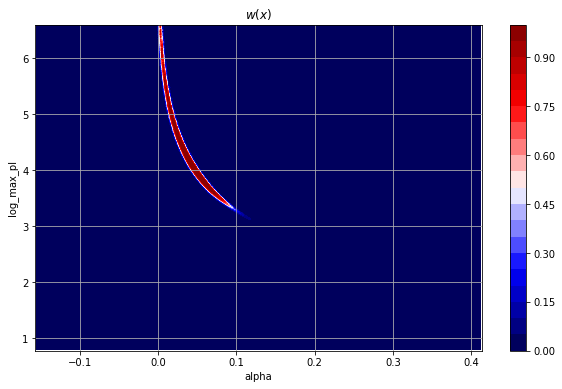

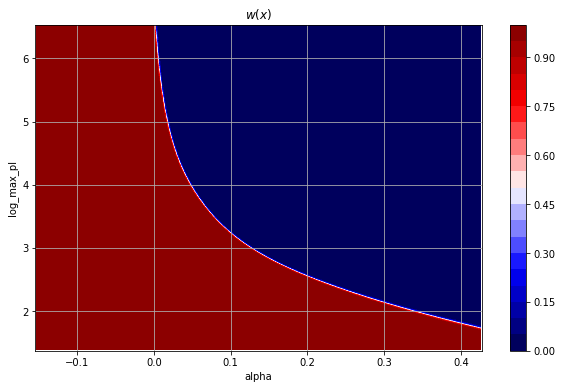

In [57]:
plot_field(w_la.w_model_np(), w_la.dataset(), r'$w(x)$', save='result_la.pdf')
plot_field(w_la3.w_model_np(), w_la3.dataset(), r'$w(x)$', save='result_la3.pdf')

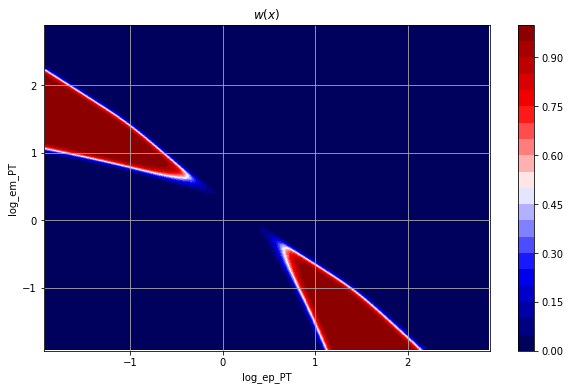

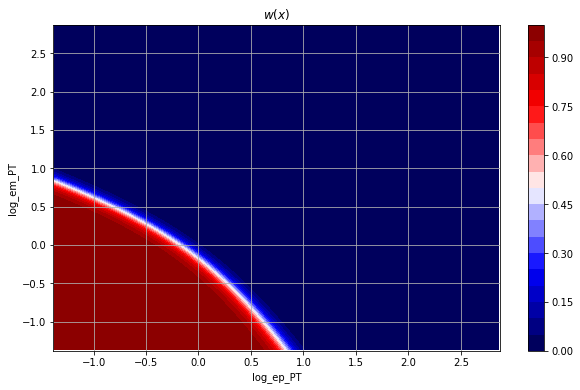

In [58]:
plot_field(w_ptpt.w_model_np(), w_ptpt.dataset(), r'$w(x)$')
plot_field(w_ptpt3.w_model_np(), w_ptpt3.dataset(), r'$w(x)$')

In [59]:
df = df.iloc[0:8,0:3]
df

Total       N   N/Total
B⁺→K⁺ee          970116  247104  0.254716
B⁺→K⁺J/ψ(→ee)    960234  929755  0.968259
B⁺→K⁺ψ(2S)(→ee)  986271  939679  0.952759
D⁺→π⁺φ(→ee)      830027  830027  1.000000

In [60]:
for name, w in [("w", w_la), ("w3", w_la3), ("wpt", w_ptpt), ("wpt3", w_ptpt3)]:
    ds = w.dataset()
    df[name] = None
    for label, idx in ds.mapping.items():
        d = ds.X[ds.Y==label]
        wd = w.w_model_np()(d)
        df.loc[df.index[idx],name] = np.mean(wd)
        df.loc[df.index[idx],"1-"+name] = 1-np.mean(wd)
df

Total       N   N/Total         w       1-w        w3  \
B⁺→K⁺ee          970116  247104  0.254716  0.130979  0.869021  0.406917   
B⁺→K⁺J/ψ(→ee)    960234  929755  0.968259  0.036813  0.963187  0.001043   
B⁺→K⁺ψ(2S)(→ee)  986271  939679  0.952759  0.036802  0.963198  0.001042   
D⁺→π⁺φ(→ee)      830027  830027  1.000000  0.036791  0.963209      None   

                     1-w3       wpt     1-wpt      wpt3    1-wpt3  
B⁺→K⁺ee          0.593083  0.068766  0.931234  0.104764  0.895236  
B⁺→K⁺J/ψ(→ee)    0.998957  0.034678  0.965322  0.020779  0.979221  
B⁺→K⁺ψ(2S)(→ee)  0.998958  0.034696  0.965304  0.020774  0.979226  
D⁺→π⁺φ(→ee)           NaN  0.034622  0.965378      None       NaN

In [61]:
def r_K(a): return 1/a[0]
def r_Jpsi(a): return 1/a[1]
def r_psi2S(a): return 1/a[2]
def R_K(a): return r_K(a)/r_Jpsi(a)
def R_psi2S(a): return r_psi2S(a)/r_Jpsi(a)

def double_ratio(a): return R_K(a)
def double_ratio_psi2S(a): return R_psi2S(a)

In [62]:
double_ratio(df["1-w"]), double_ratio_psi2S(df["1-w"])

(1.108359743400884, 0.9999886175794604)

In [63]:
1/double_ratio(df["1-w"]), 1/double_ratio_psi2S(df["1-w"])

(0.9022341400921025, 1.0000113825501005)

In [64]:
double_ratio(df["w"]), double_ratio_psi2S(df["w"])

(0.2810560589059304, 1.0002979091092772)

In [65]:
1/double_ratio(df["w"]), 1/double_ratio_psi2S(df["w"])

(3.558009045927384, 0.9997021796141287)

### Conditional plots

In [66]:
def plot_e(w_obj, feature, bins):
    ds = w_obj.dataset()
    ds_features = ds.features
    Xf, Yf, mf = make_dataset(ds_features, range(4))
    Xc, Yc, mc = make_dataset([feature], range(4))
    fn = w_obj.w_model_np()
    bins_q2 = np.linspace(0,14e6,101)
    for label, idx in ds.mapping.items():
        d = Xf[Yf==label]
        wd = 1-fn(d)
        q2d = Xc[Yc==label,0]
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        plt.step(bins[:-1], hd, where='post', label=df_index[idx])
    plt.title("e(%s) for %s" % (feature, ds_features))
    plt.legend()
    plt.grid()
    plt.show()

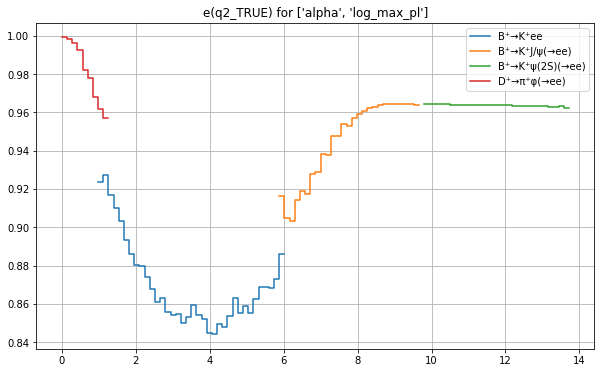

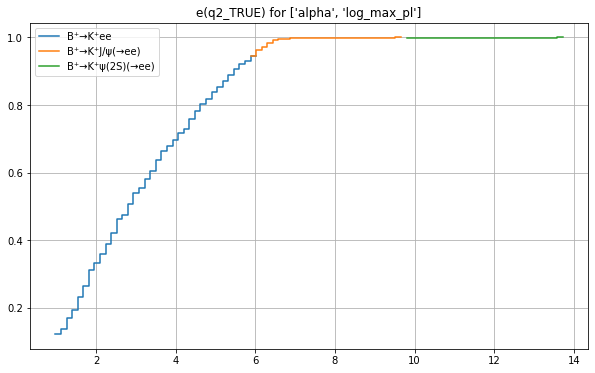

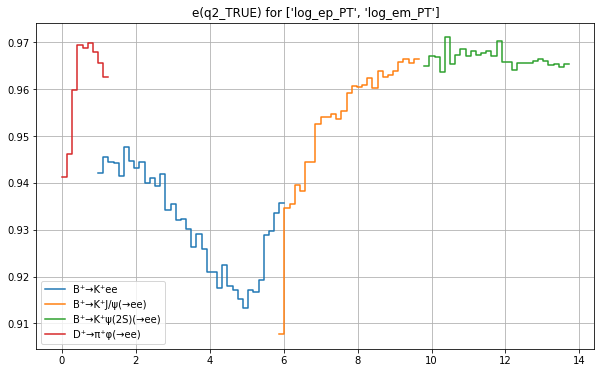

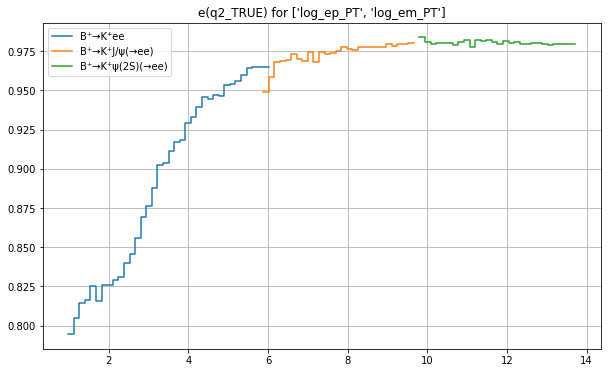

In [67]:
plot_e(w_la, "q2_TRUE", bins=np.linspace(0,14,101))
plot_e(w_la3, "q2_TRUE", bins=np.linspace(0,14,101))
plot_e(w_ptpt, "q2_TRUE", bins=np.linspace(0,14,101))
plot_e(w_ptpt3, "q2_TRUE", bins=np.linspace(0,14,101))

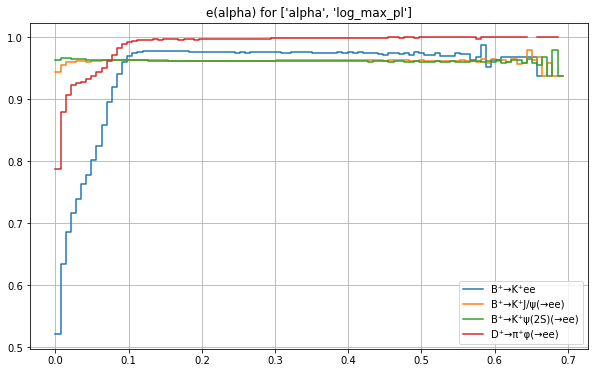

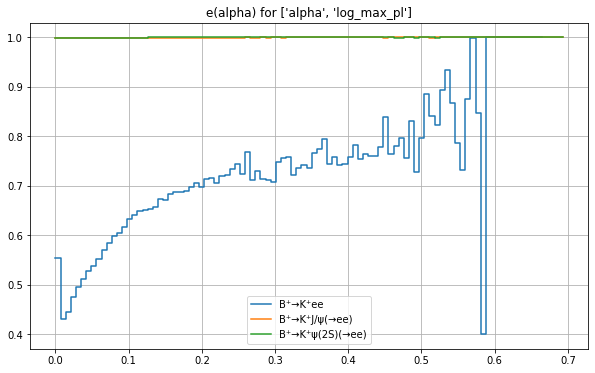

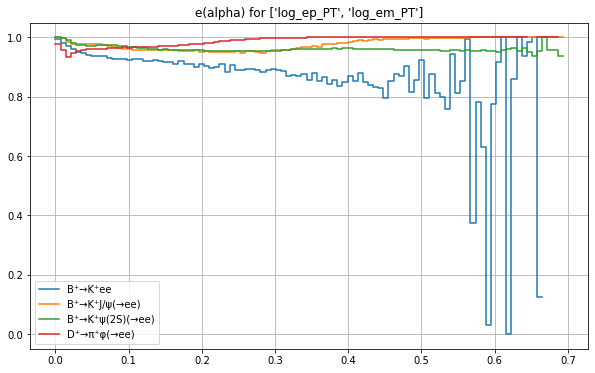

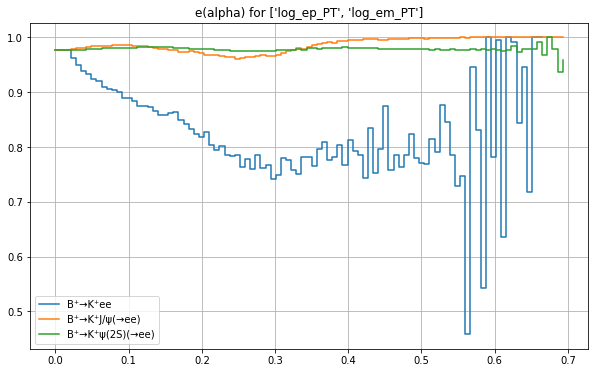

In [68]:
plot_e(w_la, "alpha", bins=np.linspace(0,0.7,101))
plot_e(w_la3, "alpha", bins=np.linspace(0,0.7,101))
plot_e(w_ptpt, "alpha", bins=np.linspace(0,0.7,101))
plot_e(w_ptpt3, "alpha", bins=np.linspace(0,0.7,101))

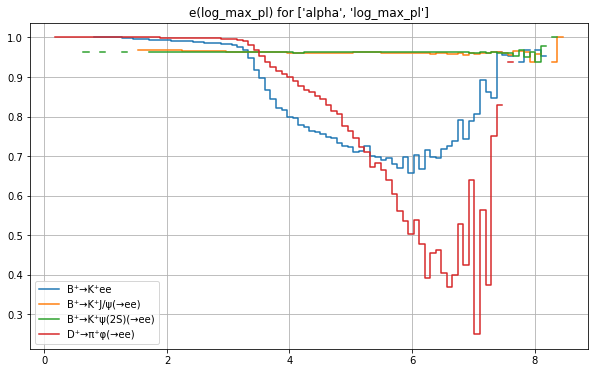

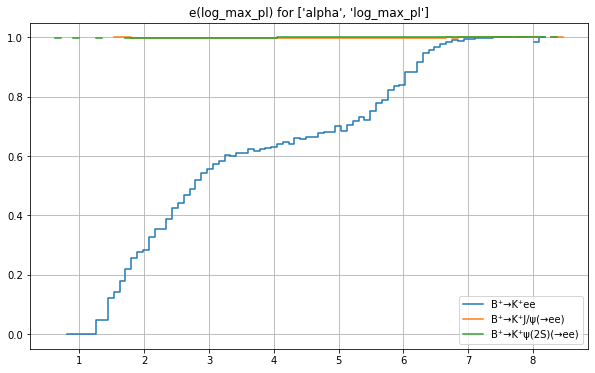

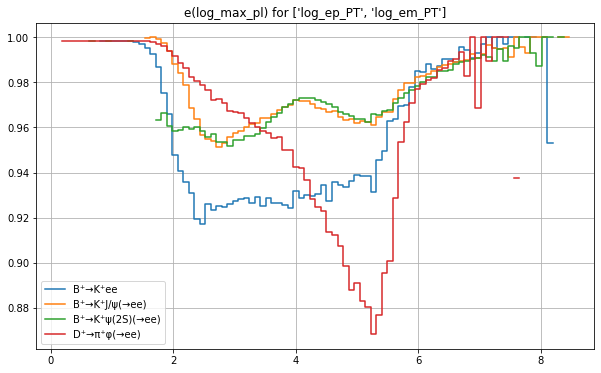

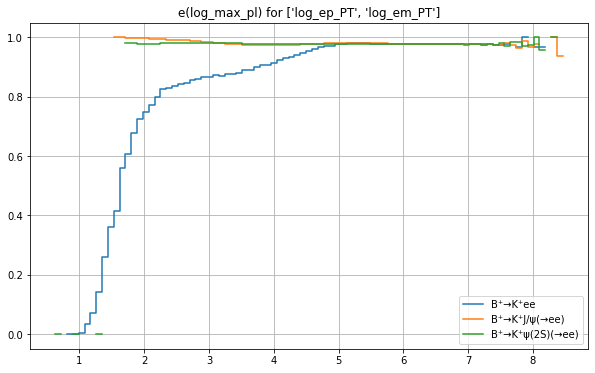

In [69]:
plot_e(w_la, "log_max_pl", bins=np.linspace(0,9,101))
plot_e(w_la3, "log_max_pl", bins=np.linspace(0,9,101))
plot_e(w_ptpt, "log_max_pl", bins=np.linspace(0,9,101))
plot_e(w_ptpt3, "log_max_pl", bins=np.linspace(0,9,101))

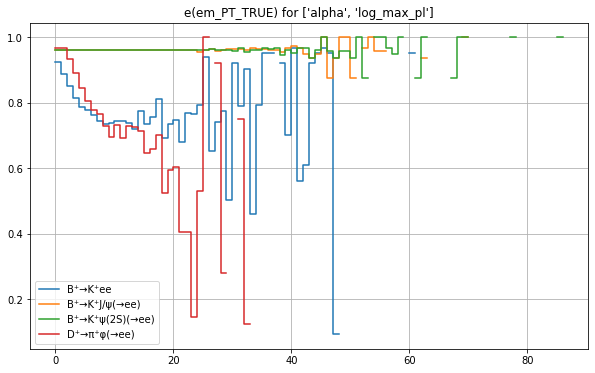

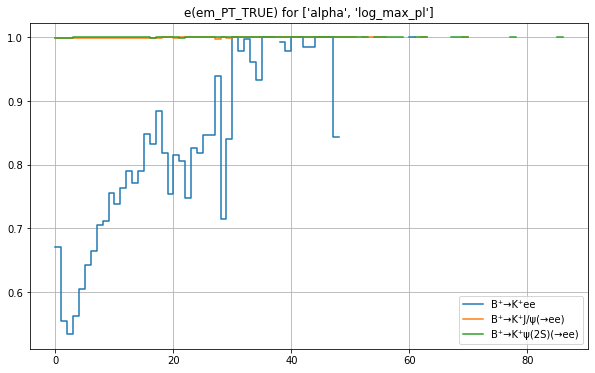

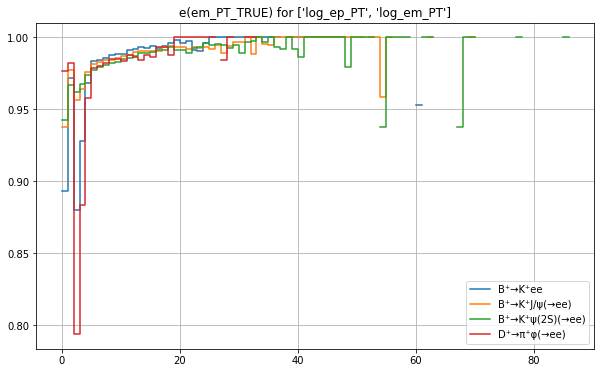

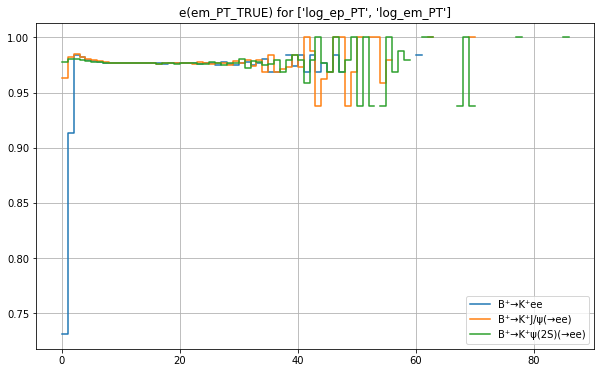

In [70]:
plot_e(w_la, "em_PT_TRUE", bins=np.linspace(0,100,101))
plot_e(w_la3, "em_PT_TRUE", bins=np.linspace(0,100,101))
plot_e(w_ptpt, "em_PT_TRUE", bins=np.linspace(0,100,101))
plot_e(w_ptpt3, "em_PT_TRUE", bins=np.linspace(0,100,101))

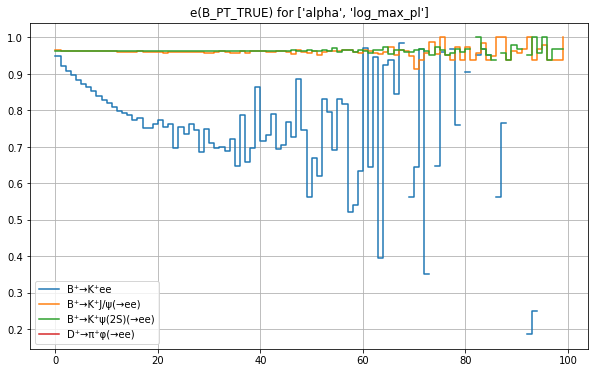

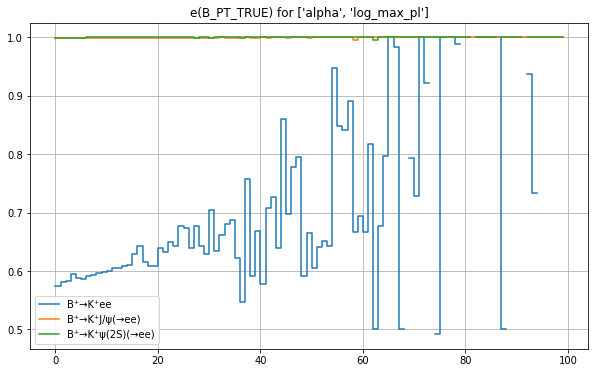

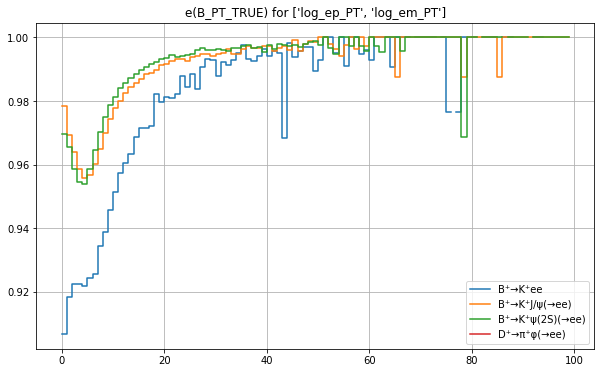

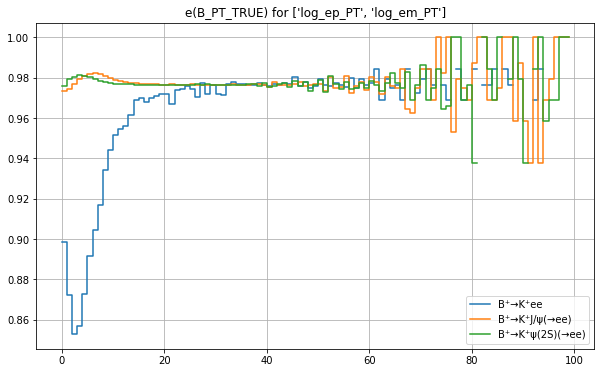

In [71]:
plot_e(w_la, "B_PT_TRUE", bins=np.linspace(0,100,101))
plot_e(w_la3, "B_PT_TRUE", bins=np.linspace(0,100,101))
plot_e(w_ptpt, "B_PT_TRUE", bins=np.linspace(0,100,101))
plot_e(w_ptpt3, "B_PT_TRUE", bins=np.linspace(0,100,101))

### Single feature

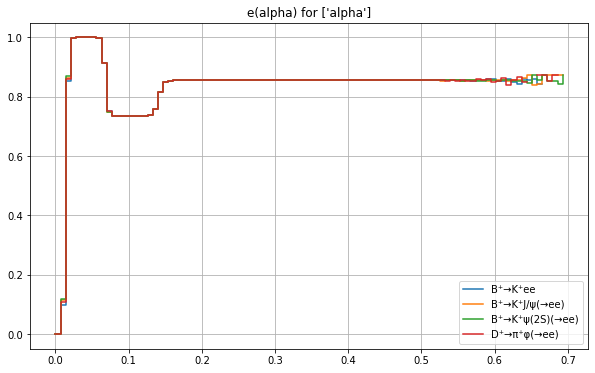

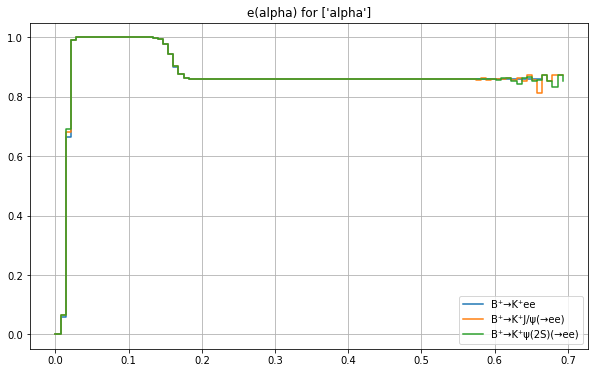

In [72]:
plot_e(w_a4, "alpha", bins=np.linspace(0,0.7,101))
plot_e(w_a3, "alpha", bins=np.linspace(0,0.7,101))

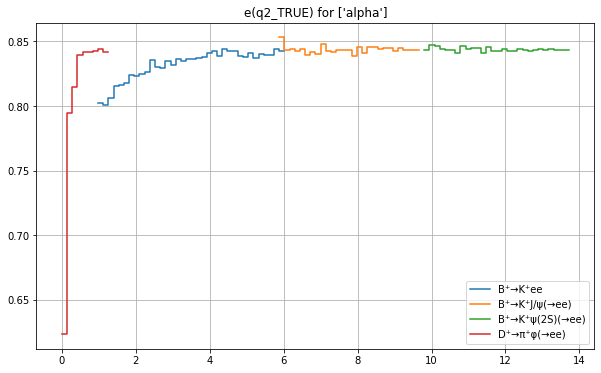

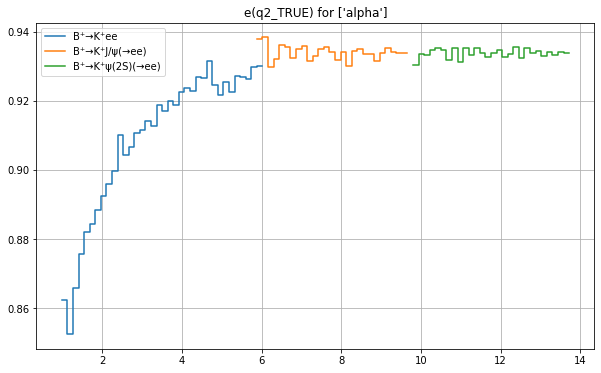

In [73]:
plot_e(w_a4, "q2_TRUE", bins=np.linspace(0,14,101))
plot_e(w_a3, "q2_TRUE", bins=np.linspace(0,14,101))